# Sciplex Dose

In [1]:
ood_seed = 8

In [2]:
num_ood = 1

In [3]:
import warnings
import os
import sys
import gc
import warnings

In [4]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [7]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [8]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [9]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Nutlin', '10.0'), 657)

Removed datapoint: 657


In [10]:
adata

AnnData object with n_obs × n_vars = 14154 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_ood-seed_expression-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [14]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="pseudo_categorical",
                non_categorical_coefficient_method="squared_difference",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1735,1559,1449,1728,1427,1022,1430,974
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1539,3590,1692,2768,1735
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 420,402,343,443,363,261,337,261
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 400,878,411,721,420
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:07<1:15:32,  7.57s/it]

Epoch 1/600:   0%|          | 1/600 [00:07<1:15:32,  7.57s/it, v_num=1, total_loss_train=2.64e+3, kl_local_train=40.9]

Epoch 2/600:   0%|          | 1/600 [00:07<1:15:32,  7.57s/it, v_num=1, total_loss_train=2.64e+3, kl_local_train=40.9]

Epoch 2/600:   0%|          | 2/600 [00:14<1:11:20,  7.16s/it, v_num=1, total_loss_train=2.64e+3, kl_local_train=40.9]

Epoch 2/600:   0%|          | 2/600 [00:14<1:11:20,  7.16s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=69.8]

Epoch 3/600:   0%|          | 2/600 [00:14<1:11:20,  7.16s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=69.8]

Epoch 3/600:   0%|          | 3/600 [00:21<1:09:53,  7.02s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=69.8]

Epoch 3/600:   0%|          | 3/600 [00:21<1:09:53,  7.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=73.9] 

Epoch 4/600:   0%|          | 3/600 [00:21<1:09:53,  7.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=73.9]

Epoch 4/600:   1%|          | 4/600 [00:28<1:08:39,  6.91s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=73.9]

Epoch 4/600:   1%|          | 4/600 [00:28<1:08:39,  6.91s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=72.5]

Epoch 5/600:   1%|          | 4/600 [00:28<1:08:39,  6.91s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=72.5]

Epoch 5/600:   1%|          | 5/600 [00:35<1:10:09,  7.07s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=72.5]

Epoch 5/600:   1%|          | 5/600 [00:35<1:10:09,  7.07s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=66.2]

Epoch 6/600:   1%|          | 5/600 [00:35<1:10:09,  7.07s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=66.2]

Epoch 6/600:   1%|          | 6/600 [00:42<1:10:06,  7.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=66.2]

Epoch 6/600:   1%|          | 6/600 [00:42<1:10:06,  7.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 7/600:   1%|          | 6/600 [00:42<1:10:06,  7.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 7/600:   1%|          | 7/600 [00:49<1:08:21,  6.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 7/600:   1%|          | 7/600 [00:49<1:08:21,  6.92s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 8/600:   1%|          | 7/600 [00:49<1:08:21,  6.92s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 8/600:   1%|▏         | 8/600 [00:55<1:07:11,  6.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 8/600:   1%|▏         | 8/600 [00:55<1:07:11,  6.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 9/600:   1%|▏         | 8/600 [00:55<1:07:11,  6.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 9/600:   2%|▏         | 9/600 [01:02<1:06:25,  6.74s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 9/600:   2%|▏         | 9/600 [01:02<1:06:25,  6.74s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 10/600:   2%|▏         | 9/600 [01:02<1:06:25,  6.74s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 10/600:   2%|▏         | 10/600 [01:09<1:06:49,  6.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 10/600:   2%|▏         | 10/600 [01:09<1:06:49,  6.80s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 11/600:   2%|▏         | 10/600 [01:09<1:06:49,  6.80s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 11/600:   2%|▏         | 11/600 [01:16<1:07:41,  6.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.041, metric_mi|condition_train=0.0399]

Epoch 11/600:   2%|▏         | 11/600 [01:16<1:07:41,  6.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]  

Epoch 12/600:   2%|▏         | 11/600 [01:16<1:07:41,  6.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 12/600:   2%|▏         | 12/600 [01:22<1:06:42,  6.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 12/600:   2%|▏         | 12/600 [01:22<1:06:42,  6.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=63, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 13/600:   2%|▏         | 12/600 [01:22<1:06:42,  6.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=63, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 13/600:   2%|▏         | 13/600 [01:29<1:05:55,  6.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=63, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 13/600:   2%|▏         | 13/600 [01:29<1:05:55,  6.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=72, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 14/600:   2%|▏         | 13/600 [01:29<1:05:55,  6.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=72, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 14/600:   2%|▏         | 14/600 [01:36<1:05:19,  6.69s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=72, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 14/600:   2%|▏         | 14/600 [01:36<1:05:19,  6.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 15/600:   2%|▏         | 14/600 [01:36<1:05:19,  6.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 15/600:   2%|▎         | 15/600 [01:42<1:05:51,  6.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 15/600:   2%|▎         | 15/600 [01:42<1:05:51,  6.75s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173] 

Epoch 16/600:   2%|▎         | 15/600 [01:43<1:05:51,  6.75s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 16/600:   3%|▎         | 16/600 [01:50<1:06:49,  6.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.173]

Epoch 16/600:   3%|▎         | 16/600 [01:50<1:06:49,  6.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=117, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158] 

Epoch 17/600:   3%|▎         | 16/600 [01:50<1:06:49,  6.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=117, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 17/600:   3%|▎         | 17/600 [01:56<1:05:56,  6.79s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=117, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 17/600:   3%|▎         | 17/600 [01:56<1:05:56,  6.79s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 18/600:   3%|▎         | 17/600 [01:56<1:05:56,  6.79s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 18/600:   3%|▎         | 18/600 [02:03<1:05:16,  6.73s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 18/600:   3%|▎         | 18/600 [02:03<1:05:16,  6.73s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=149, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 19/600:   3%|▎         | 18/600 [02:03<1:05:16,  6.73s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=149, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 19/600:   3%|▎         | 19/600 [02:09<1:04:50,  6.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=149, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 19/600:   3%|▎         | 19/600 [02:09<1:04:50,  6.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=169, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 20/600:   3%|▎         | 19/600 [02:09<1:04:50,  6.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=169, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 20/600:   3%|▎         | 20/600 [02:17<1:06:02,  6.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=169, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 20/600:   3%|▎         | 20/600 [02:17<1:06:02,  6.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=195, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 21/600:   3%|▎         | 20/600 [02:17<1:06:02,  6.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=195, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 21/600:   4%|▎         | 21/600 [02:24<1:06:48,  6.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=195, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.158]

Epoch 21/600:   4%|▎         | 21/600 [02:24<1:06:48,  6.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=210, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21] 

Epoch 22/600:   4%|▎         | 21/600 [02:24<1:06:48,  6.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=210, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 22/600:   4%|▎         | 22/600 [02:30<1:05:50,  6.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=210, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 22/600:   4%|▎         | 22/600 [02:30<1:05:50,  6.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=227, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 23/600:   4%|▎         | 22/600 [02:30<1:05:50,  6.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=227, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 23/600:   4%|▍         | 23/600 [02:37<1:05:07,  6.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=227, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 23/600:   4%|▍         | 23/600 [02:37<1:05:07,  6.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=235, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 24/600:   4%|▍         | 23/600 [02:37<1:05:07,  6.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=235, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 24/600:   4%|▍         | 24/600 [02:44<1:04:33,  6.73s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=235, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 24/600:   4%|▍         | 24/600 [02:44<1:04:33,  6.73s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=260, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 25/600:   4%|▍         | 24/600 [02:44<1:04:33,  6.73s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=260, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 25/600:   4%|▍         | 25/600 [02:51<1:05:27,  6.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=260, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 25/600:   4%|▍         | 25/600 [02:51<1:05:27,  6.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=270, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 26/600:   4%|▍         | 25/600 [02:51<1:05:27,  6.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=270, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 26/600:   4%|▍         | 26/600 [02:58<1:06:14,  6.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=270, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.21]

Epoch 26/600:   4%|▍         | 26/600 [02:58<1:06:14,  6.92s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=275, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 27/600:   4%|▍         | 26/600 [02:58<1:06:14,  6.92s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=275, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 27/600:   4%|▍         | 27/600 [03:04<1:05:16,  6.83s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=275, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 27/600:   4%|▍         | 27/600 [03:04<1:05:16,  6.83s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=290, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 28/600:   4%|▍         | 27/600 [03:04<1:05:16,  6.83s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=290, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 28/600:   5%|▍         | 28/600 [03:11<1:04:34,  6.77s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=290, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 28/600:   5%|▍         | 28/600 [03:11<1:04:34,  6.77s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=290, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 29/600:   5%|▍         | 28/600 [03:11<1:04:34,  6.77s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=290, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 29/600:   5%|▍         | 29/600 [03:18<1:04:03,  6.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=290, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 29/600:   5%|▍         | 29/600 [03:18<1:04:03,  6.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=288, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 30/600:   5%|▍         | 29/600 [03:18<1:04:03,  6.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=288, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 30/600:   5%|▌         | 30/600 [03:25<1:05:27,  6.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=288, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 30/600:   5%|▌         | 30/600 [03:25<1:05:27,  6.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=298, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 31/600:   5%|▌         | 30/600 [03:25<1:05:27,  6.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=298, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 31/600:   5%|▌         | 31/600 [03:32<1:06:03,  6.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=298, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.241]

Epoch 31/600:   5%|▌         | 31/600 [03:32<1:06:03,  6.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=296, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 32/600:   5%|▌         | 31/600 [03:32<1:06:03,  6.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=296, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 32/600:   5%|▌         | 32/600 [03:39<1:05:02,  6.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=296, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 32/600:   5%|▌         | 32/600 [03:39<1:05:02,  6.87s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=301, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 33/600:   5%|▌         | 32/600 [03:39<1:05:02,  6.87s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=301, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 33/600:   6%|▌         | 33/600 [03:45<1:04:13,  6.80s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=301, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 33/600:   6%|▌         | 33/600 [03:45<1:04:13,  6.80s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=304, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 34/600:   6%|▌         | 33/600 [03:45<1:04:13,  6.80s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=304, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 34/600:   6%|▌         | 34/600 [03:52<1:03:38,  6.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=304, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 34/600:   6%|▌         | 34/600 [03:52<1:03:38,  6.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=301, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 35/600:   6%|▌         | 34/600 [03:52<1:03:38,  6.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=301, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 35/600:   6%|▌         | 35/600 [03:59<1:05:07,  6.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=301, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 35/600:   6%|▌         | 35/600 [03:59<1:05:07,  6.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=307, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 36/600:   6%|▌         | 35/600 [04:00<1:05:07,  6.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=307, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 36/600:   6%|▌         | 36/600 [04:06<1:05:40,  6.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=307, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 36/600:   6%|▌         | 36/600 [04:06<1:05:40,  6.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=310, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246] 

Epoch 37/600:   6%|▌         | 36/600 [04:06<1:05:40,  6.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=310, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 37/600:   6%|▌         | 37/600 [04:13<1:04:37,  6.89s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=310, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 37/600:   6%|▌         | 37/600 [04:13<1:04:37,  6.89s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=313, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 38/600:   6%|▌         | 37/600 [04:13<1:04:37,  6.89s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=313, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 38/600:   6%|▋         | 38/600 [04:20<1:03:57,  6.83s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=313, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 38/600:   6%|▋         | 38/600 [04:20<1:03:57,  6.83s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=311, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 39/600:   6%|▋         | 38/600 [04:20<1:03:57,  6.83s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=311, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 39/600:   6%|▋         | 39/600 [04:27<1:03:35,  6.80s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=311, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 39/600:   6%|▋         | 39/600 [04:27<1:03:35,  6.80s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=308, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 40/600:   6%|▋         | 39/600 [04:27<1:03:35,  6.80s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=308, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 40/600:   7%|▋         | 40/600 [04:34<1:04:17,  6.89s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=308, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 40/600:   7%|▋         | 40/600 [04:34<1:04:17,  6.89s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=306, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 41/600:   7%|▋         | 40/600 [04:34<1:04:17,  6.89s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=306, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 41/600:   7%|▋         | 41/600 [04:41<1:05:10,  7.00s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=306, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.246]

Epoch 41/600:   7%|▋         | 41/600 [04:41<1:05:10,  7.00s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=301, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 42/600:   7%|▋         | 41/600 [04:41<1:05:10,  7.00s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=301, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 42/600:   7%|▋         | 42/600 [04:48<1:04:16,  6.91s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=301, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 42/600:   7%|▋         | 42/600 [04:48<1:04:16,  6.91s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=304, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247] 

Epoch 43/600:   7%|▋         | 42/600 [04:48<1:04:16,  6.91s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=304, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 43/600:   7%|▋         | 43/600 [04:54<1:03:40,  6.86s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=304, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 43/600:   7%|▋         | 43/600 [04:54<1:03:40,  6.86s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=297, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 44/600:   7%|▋         | 43/600 [04:54<1:03:40,  6.86s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=297, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 44/600:   7%|▋         | 44/600 [05:01<1:03:06,  6.81s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=297, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 44/600:   7%|▋         | 44/600 [05:01<1:03:06,  6.81s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=295, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 45/600:   7%|▋         | 44/600 [05:01<1:03:06,  6.81s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=295, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 45/600:   8%|▊         | 45/600 [05:08<1:03:32,  6.87s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=295, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 45/600:   8%|▊         | 45/600 [05:08<1:03:32,  6.87s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=288, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 46/600:   8%|▊         | 45/600 [05:09<1:03:32,  6.87s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=288, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 46/600:   8%|▊         | 46/600 [05:15<1:04:14,  6.96s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=288, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.247]

Epoch 46/600:   8%|▊         | 46/600 [05:15<1:04:14,  6.96s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=288, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 47/600:   8%|▊         | 46/600 [05:15<1:04:14,  6.96s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=288, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 47/600:   8%|▊         | 47/600 [05:22<1:03:17,  6.87s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=288, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 47/600:   8%|▊         | 47/600 [05:22<1:03:17,  6.87s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=291, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 48/600:   8%|▊         | 47/600 [05:22<1:03:17,  6.87s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=291, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 48/600:   8%|▊         | 48/600 [05:28<1:02:38,  6.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=291, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 48/600:   8%|▊         | 48/600 [05:28<1:02:38,  6.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=281, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 49/600:   8%|▊         | 48/600 [05:29<1:02:38,  6.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=281, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 49/600:   8%|▊         | 49/600 [05:35<1:02:04,  6.76s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=281, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 49/600:   8%|▊         | 49/600 [05:35<1:02:04,  6.76s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=287, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 50/600:   8%|▊         | 49/600 [05:35<1:02:04,  6.76s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=287, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 50/600:   8%|▊         | 50/600 [05:42<1:03:31,  6.93s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=287, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 50/600:   8%|▊         | 50/600 [05:42<1:03:31,  6.93s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=281, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 51/600:   8%|▊         | 50/600 [05:43<1:03:31,  6.93s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=281, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 51/600:   8%|▊         | 51/600 [05:50<1:04:01,  7.00s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=281, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.256]

Epoch 51/600:   8%|▊         | 51/600 [05:50<1:04:01,  7.00s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=287, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26] 

Epoch 52/600:   8%|▊         | 51/600 [05:50<1:04:01,  7.00s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=287, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 52/600:   9%|▊         | 52/600 [05:56<1:02:57,  6.89s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=287, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 52/600:   9%|▊         | 52/600 [05:56<1:02:57,  6.89s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=280, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 53/600:   9%|▊         | 52/600 [05:56<1:02:57,  6.89s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=280, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 53/600:   9%|▉         | 53/600 [06:03<1:02:09,  6.82s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=280, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 53/600:   9%|▉         | 53/600 [06:03<1:02:09,  6.82s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=274, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 54/600:   9%|▉         | 53/600 [06:03<1:02:09,  6.82s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=274, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 54/600:   9%|▉         | 54/600 [06:10<1:01:37,  6.77s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=274, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 54/600:   9%|▉         | 54/600 [06:10<1:01:37,  6.77s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 55/600:   9%|▉         | 54/600 [06:10<1:01:37,  6.77s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 55/600:   9%|▉         | 55/600 [06:17<1:02:58,  6.93s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 55/600:   9%|▉         | 55/600 [06:17<1:02:58,  6.93s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=260, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 56/600:   9%|▉         | 55/600 [06:17<1:02:58,  6.93s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=260, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 56/600:   9%|▉         | 56/600 [06:24<1:04:03,  7.07s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=260, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.26]

Epoch 56/600:   9%|▉         | 56/600 [06:24<1:04:03,  7.07s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=262, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 57/600:   9%|▉         | 56/600 [06:24<1:04:03,  7.07s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=262, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 57/600:  10%|▉         | 57/600 [06:31<1:03:27,  7.01s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=262, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 57/600:  10%|▉         | 57/600 [06:31<1:03:27,  7.01s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 58/600:  10%|▉         | 57/600 [06:31<1:03:27,  7.01s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 58/600:  10%|▉         | 58/600 [06:38<1:02:58,  6.97s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 58/600:  10%|▉         | 58/600 [06:38<1:02:58,  6.97s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=259, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 59/600:  10%|▉         | 58/600 [06:38<1:02:58,  6.97s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=259, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 59/600:  10%|▉         | 59/600 [06:45<1:02:35,  6.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=259, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 59/600:  10%|▉         | 59/600 [06:45<1:02:35,  6.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=253, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 60/600:  10%|▉         | 59/600 [06:45<1:02:35,  6.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=253, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 60/600:  10%|█         | 60/600 [06:52<1:03:33,  7.06s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=253, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 60/600:  10%|█         | 60/600 [06:52<1:03:33,  7.06s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=251, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 61/600:  10%|█         | 60/600 [06:53<1:03:33,  7.06s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=251, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 61/600:  10%|█         | 61/600 [07:00<1:04:18,  7.16s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=251, metric_mi|dose_training_train=0.239, metric_mi|condition_train=0.26]

Epoch 61/600:  10%|█         | 61/600 [07:00<1:04:18,  7.16s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=252, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 62/600:  10%|█         | 61/600 [07:00<1:04:18,  7.16s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=252, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 62/600:  10%|█         | 62/600 [07:07<1:03:26,  7.07s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=252, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 62/600:  10%|█         | 62/600 [07:07<1:03:26,  7.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=249, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261] 

Epoch 63/600:  10%|█         | 62/600 [07:07<1:03:26,  7.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=249, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 63/600:  10%|█         | 63/600 [07:13<1:02:45,  7.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=249, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 63/600:  10%|█         | 63/600 [07:13<1:02:45,  7.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 64/600:  10%|█         | 63/600 [07:13<1:02:45,  7.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 64/600:  11%|█         | 64/600 [07:20<1:02:16,  6.97s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 64/600:  11%|█         | 64/600 [07:20<1:02:16,  6.97s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 65/600:  11%|█         | 64/600 [07:20<1:02:16,  6.97s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 65/600:  11%|█         | 65/600 [07:28<1:03:04,  7.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 65/600:  11%|█         | 65/600 [07:28<1:03:04,  7.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 66/600:  11%|█         | 65/600 [07:28<1:03:04,  7.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 66/600:  11%|█         | 66/600 [07:35<1:03:46,  7.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.261]

Epoch 66/600:  11%|█         | 66/600 [07:35<1:03:46,  7.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 67/600:  11%|█         | 66/600 [07:35<1:03:46,  7.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 67/600:  11%|█         | 67/600 [07:42<1:02:53,  7.08s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 67/600:  11%|█         | 67/600 [07:42<1:02:53,  7.08s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 68/600:  11%|█         | 67/600 [07:42<1:02:53,  7.08s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 68/600:  11%|█▏        | 68/600 [07:49<1:02:16,  7.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 68/600:  11%|█▏        | 68/600 [07:49<1:02:16,  7.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=234, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 69/600:  11%|█▏        | 68/600 [07:49<1:02:16,  7.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=234, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 69/600:  12%|█▏        | 69/600 [07:56<1:01:46,  6.98s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=234, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 69/600:  12%|█▏        | 69/600 [07:56<1:01:46,  6.98s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=230, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 70/600:  12%|█▏        | 69/600 [07:56<1:01:46,  6.98s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=230, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 70/600:  12%|█▏        | 70/600 [08:03<1:02:29,  7.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=230, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 70/600:  12%|█▏        | 70/600 [08:03<1:02:29,  7.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=232, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 71/600:  12%|█▏        | 70/600 [08:03<1:02:29,  7.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=232, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 71/600:  12%|█▏        | 71/600 [08:10<1:03:11,  7.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=232, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.253]

Epoch 71/600:  12%|█▏        | 71/600 [08:10<1:03:11,  7.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=234, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 72/600:  12%|█▏        | 71/600 [08:10<1:03:11,  7.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=234, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 72/600:  12%|█▏        | 72/600 [08:17<1:02:16,  7.08s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=234, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 72/600:  12%|█▏        | 72/600 [08:17<1:02:16,  7.08s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=233, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 73/600:  12%|█▏        | 72/600 [08:17<1:02:16,  7.08s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=233, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 73/600:  12%|█▏        | 73/600 [08:24<1:01:37,  7.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=233, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 73/600:  12%|█▏        | 73/600 [08:24<1:01:37,  7.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=227, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 74/600:  12%|█▏        | 73/600 [08:24<1:01:37,  7.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=227, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 74/600:  12%|█▏        | 74/600 [08:31<1:01:08,  6.97s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=227, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 74/600:  12%|█▏        | 74/600 [08:31<1:01:08,  6.97s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=220, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 75/600:  12%|█▏        | 74/600 [08:31<1:01:08,  6.97s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=220, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 75/600:  12%|█▎        | 75/600 [08:38<1:01:55,  7.08s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=220, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 75/600:  12%|█▎        | 75/600 [08:38<1:01:55,  7.08s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=217, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 76/600:  12%|█▎        | 75/600 [08:39<1:01:55,  7.08s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=217, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 76/600:  13%|█▎        | 76/600 [08:46<1:02:36,  7.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=217, metric_mi|dose_training_train=0.256, metric_mi|condition_train=0.252]

Epoch 76/600:  13%|█▎        | 76/600 [08:46<1:02:36,  7.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=218, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 77/600:  13%|█▎        | 76/600 [08:46<1:02:36,  7.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=218, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 77/600:  13%|█▎        | 77/600 [08:52<1:01:46,  7.09s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=218, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 77/600:  13%|█▎        | 77/600 [08:52<1:01:46,  7.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=209, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 78/600:  13%|█▎        | 77/600 [08:52<1:01:46,  7.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=209, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 78/600:  13%|█▎        | 78/600 [08:59<1:01:08,  7.03s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=209, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 78/600:  13%|█▎        | 78/600 [08:59<1:01:08,  7.03s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 79/600:  13%|█▎        | 78/600 [08:59<1:01:08,  7.03s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 79/600:  13%|█▎        | 79/600 [09:06<1:00:40,  6.99s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 79/600:  13%|█▎        | 79/600 [09:06<1:00:40,  6.99s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 80/600:  13%|█▎        | 79/600 [09:06<1:00:40,  6.99s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 80/600:  13%|█▎        | 80/600 [09:13<1:00:34,  6.99s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 80/600:  13%|█▎        | 80/600 [09:13<1:00:34,  6.99s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=211, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 81/600:  13%|█▎        | 80/600 [09:14<1:00:34,  6.99s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=211, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 81/600:  14%|█▎        | 81/600 [09:21<1:01:29,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=211, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.253]

Epoch 81/600:  14%|█▎        | 81/600 [09:21<1:01:29,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 82/600:  14%|█▎        | 81/600 [09:21<1:01:29,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 82/600:  14%|█▎        | 82/600 [09:28<1:01:27,  7.12s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 82/600:  14%|█▎        | 82/600 [09:28<1:01:27,  7.12s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=209, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 83/600:  14%|█▎        | 82/600 [09:28<1:01:27,  7.12s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=209, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 83/600:  14%|█▍        | 83/600 [09:35<1:00:47,  7.06s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=209, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 83/600:  14%|█▍        | 83/600 [09:35<1:00:47,  7.06s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=203, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 84/600:  14%|█▍        | 83/600 [09:35<1:00:47,  7.06s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=203, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 84/600:  14%|█▍        | 84/600 [09:42<1:00:16,  7.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=203, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 84/600:  14%|█▍        | 84/600 [09:42<1:00:16,  7.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=203, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 85/600:  14%|█▍        | 84/600 [09:42<1:00:16,  7.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=203, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 85/600:  14%|█▍        | 85/600 [09:49<1:01:00,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=203, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 85/600:  14%|█▍        | 85/600 [09:49<1:01:00,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=201, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 86/600:  14%|█▍        | 85/600 [09:49<1:01:00,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=201, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 86/600:  14%|█▍        | 86/600 [09:56<1:02:01,  7.24s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=201, metric_mi|dose_training_train=0.246, metric_mi|condition_train=0.252]

Epoch 86/600:  14%|█▍        | 86/600 [09:56<1:02:01,  7.24s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=201, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25] 

Epoch 87/600:  14%|█▍        | 86/600 [09:56<1:02:01,  7.24s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=201, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 87/600:  14%|█▍        | 87/600 [10:04<1:01:26,  7.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=201, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 87/600:  14%|█▍        | 87/600 [10:04<1:01:26,  7.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=196, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 88/600:  14%|█▍        | 87/600 [10:04<1:01:26,  7.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=196, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 88/600:  15%|█▍        | 88/600 [10:11<1:00:57,  7.14s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=196, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 88/600:  15%|█▍        | 88/600 [10:11<1:00:57,  7.14s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=192, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 89/600:  15%|█▍        | 88/600 [10:11<1:00:57,  7.14s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=192, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 89/600:  15%|█▍        | 89/600 [10:18<1:00:33,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=192, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 89/600:  15%|█▍        | 89/600 [10:18<1:00:33,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 90/600:  15%|█▍        | 89/600 [10:18<1:00:33,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 90/600:  15%|█▌        | 90/600 [10:25<1:00:46,  7.15s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 90/600:  15%|█▌        | 90/600 [10:25<1:00:46,  7.15s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 91/600:  15%|█▌        | 90/600 [10:25<1:00:46,  7.15s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 91/600:  15%|█▌        | 91/600 [10:32<1:01:38,  7.27s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.25]

Epoch 91/600:  15%|█▌        | 91/600 [10:32<1:01:38,  7.27s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=187, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 92/600:  15%|█▌        | 91/600 [10:32<1:01:38,  7.27s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=187, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 92/600:  15%|█▌        | 92/600 [10:39<1:00:55,  7.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=187, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 92/600:  15%|█▌        | 92/600 [10:39<1:00:55,  7.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=188, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 93/600:  15%|█▌        | 92/600 [10:39<1:00:55,  7.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=188, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 93/600:  16%|█▌        | 93/600 [10:46<1:00:22,  7.15s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=188, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 93/600:  16%|█▌        | 93/600 [10:46<1:00:22,  7.15s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 94/600:  16%|█▌        | 93/600 [10:46<1:00:22,  7.15s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 94/600:  16%|█▌        | 94/600 [10:53<59:59,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]  

Epoch 94/600:  16%|█▌        | 94/600 [10:53<59:59,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=183, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 95/600:  16%|█▌        | 94/600 [10:54<59:59,  7.11s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=183, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 95/600:  16%|█▌        | 95/600 [11:01<1:00:14,  7.16s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=183, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 95/600:  16%|█▌        | 95/600 [11:01<1:00:14,  7.16s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 96/600:  16%|█▌        | 95/600 [11:01<1:00:14,  7.16s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 96/600:  16%|█▌        | 96/600 [11:08<1:00:43,  7.23s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.244]

Epoch 96/600:  16%|█▌        | 96/600 [11:08<1:00:43,  7.23s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=179, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 97/600:  16%|█▌        | 96/600 [11:08<1:00:43,  7.23s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=179, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 97/600:  16%|█▌        | 97/600 [11:15<59:46,  7.13s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=179, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]  

Epoch 97/600:  16%|█▌        | 97/600 [11:15<59:46,  7.13s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=178, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 98/600:  16%|█▌        | 97/600 [11:15<59:46,  7.13s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=178, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 98/600:  16%|█▋        | 98/600 [11:22<58:58,  7.05s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=178, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 98/600:  16%|█▋        | 98/600 [11:22<58:58,  7.05s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=177, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 99/600:  16%|█▋        | 98/600 [11:22<58:58,  7.05s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=177, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 99/600:  16%|█▋        | 99/600 [11:29<58:25,  7.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=177, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 99/600:  16%|█▋        | 99/600 [11:29<58:25,  7.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=177, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 100/600:  16%|█▋        | 99/600 [11:29<58:25,  7.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=177, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 100/600:  17%|█▋        | 100/600 [11:36<59:11,  7.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=177, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 100/600:  17%|█▋        | 100/600 [11:36<59:11,  7.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=175, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 101/600:  17%|█▋        | 100/600 [11:37<59:11,  7.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=175, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 101/600:  17%|█▋        | 101/600 [11:44<59:45,  7.18s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=175, metric_mi|dose_training_train=0.233, metric_mi|condition_train=0.251]

Epoch 101/600:  17%|█▋        | 101/600 [11:44<59:45,  7.18s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=176, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25] 

Epoch 102/600:  17%|█▋        | 101/600 [11:44<59:45,  7.18s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=176, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 102/600:  17%|█▋        | 102/600 [11:50<58:51,  7.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=176, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 102/600:  17%|█▋        | 102/600 [11:50<58:51,  7.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=174, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 103/600:  17%|█▋        | 102/600 [11:50<58:51,  7.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=174, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 103/600:  17%|█▋        | 103/600 [11:57<58:12,  7.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=174, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 103/600:  17%|█▋        | 103/600 [11:57<58:12,  7.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 104/600:  17%|█▋        | 103/600 [11:57<58:12,  7.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 104/600:  17%|█▋        | 104/600 [12:04<57:43,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 104/600:  17%|█▋        | 104/600 [12:04<57:43,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 105/600:  17%|█▋        | 104/600 [12:04<57:43,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 105/600:  18%|█▊        | 105/600 [12:11<57:35,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 105/600:  18%|█▊        | 105/600 [12:11<57:35,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 106/600:  18%|█▊        | 105/600 [12:12<57:35,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 106/600:  18%|█▊        | 106/600 [12:19<58:28,  7.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.25]

Epoch 106/600:  18%|█▊        | 106/600 [12:19<58:28,  7.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 107/600:  18%|█▊        | 106/600 [12:19<58:28,  7.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 107/600:  18%|█▊        | 107/600 [12:25<57:46,  7.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 107/600:  18%|█▊        | 107/600 [12:25<57:46,  7.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 108/600:  18%|█▊        | 107/600 [12:25<57:46,  7.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 108/600:  18%|█▊        | 108/600 [12:32<57:15,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 108/600:  18%|█▊        | 108/600 [12:32<57:15,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 109/600:  18%|█▊        | 108/600 [12:32<57:15,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 109/600:  18%|█▊        | 109/600 [12:39<56:52,  6.95s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 109/600:  18%|█▊        | 109/600 [12:39<56:52,  6.95s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 110/600:  18%|█▊        | 109/600 [12:39<56:52,  6.95s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 110/600:  18%|█▊        | 110/600 [12:46<57:38,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 110/600:  18%|█▊        | 110/600 [12:46<57:38,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=168, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 111/600:  18%|█▊        | 110/600 [12:47<57:38,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=168, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 111/600:  18%|█▊        | 111/600 [12:54<58:15,  7.15s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=168, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.248]

Epoch 111/600:  18%|█▊        | 111/600 [12:54<58:15,  7.15s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 112/600:  18%|█▊        | 111/600 [12:54<58:15,  7.15s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 112/600:  19%|█▊        | 112/600 [13:01<57:26,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 112/600:  19%|█▊        | 112/600 [13:01<57:26,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=168, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 113/600:  19%|█▊        | 112/600 [13:01<57:26,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=168, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 113/600:  19%|█▉        | 113/600 [13:08<56:50,  7.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=168, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 113/600:  19%|█▉        | 113/600 [13:08<56:50,  7.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=167, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 114/600:  19%|█▉        | 113/600 [13:08<56:50,  7.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=167, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 114/600:  19%|█▉        | 114/600 [13:14<56:24,  6.96s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=167, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 114/600:  19%|█▉        | 114/600 [13:14<56:24,  6.96s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 115/600:  19%|█▉        | 114/600 [13:14<56:24,  6.96s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 115/600:  19%|█▉        | 115/600 [13:22<57:05,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 115/600:  19%|█▉        | 115/600 [13:22<57:05,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 116/600:  19%|█▉        | 115/600 [13:22<57:05,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 116/600:  19%|█▉        | 116/600 [13:29<57:43,  7.16s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.242]

Epoch 116/600:  19%|█▉        | 116/600 [13:29<57:43,  7.16s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 117/600:  19%|█▉        | 116/600 [13:29<57:43,  7.16s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 117/600:  20%|█▉        | 117/600 [13:36<56:59,  7.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 117/600:  20%|█▉        | 117/600 [13:36<56:59,  7.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 118/600:  20%|█▉        | 117/600 [13:36<56:59,  7.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 118/600:  20%|█▉        | 118/600 [13:43<56:24,  7.02s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 118/600:  20%|█▉        | 118/600 [13:43<56:24,  7.02s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 119/600:  20%|█▉        | 118/600 [13:43<56:24,  7.02s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 119/600:  20%|█▉        | 119/600 [13:50<55:57,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 119/600:  20%|█▉        | 119/600 [13:50<55:57,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=162, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 120/600:  20%|█▉        | 119/600 [13:50<55:57,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=162, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 120/600:  20%|██        | 120/600 [13:57<56:36,  7.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=162, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 120/600:  20%|██        | 120/600 [13:57<56:36,  7.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 121/600:  20%|██        | 120/600 [13:58<56:36,  7.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 121/600:  20%|██        | 121/600 [14:04<57:10,  7.16s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.243]

Epoch 121/600:  20%|██        | 121/600 [14:04<57:10,  7.16s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=162, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 122/600:  20%|██        | 121/600 [14:04<57:10,  7.16s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=162, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 122/600:  20%|██        | 122/600 [14:11<56:20,  7.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=162, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 122/600:  20%|██        | 122/600 [14:11<56:20,  7.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 123/600:  20%|██        | 122/600 [14:11<56:20,  7.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 123/600:  20%|██        | 123/600 [14:18<55:43,  7.01s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 123/600:  20%|██        | 123/600 [14:18<55:43,  7.01s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 124/600:  20%|██        | 123/600 [14:18<55:43,  7.01s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 124/600:  21%|██        | 124/600 [14:25<55:29,  6.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 124/600:  21%|██        | 124/600 [14:25<55:29,  6.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 125/600:  21%|██        | 124/600 [14:25<55:29,  6.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 125/600:  21%|██        | 125/600 [14:32<56:06,  7.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 125/600:  21%|██        | 125/600 [14:32<56:06,  7.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 126/600:  21%|██        | 125/600 [14:33<56:06,  7.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 126/600:  21%|██        | 126/600 [14:40<56:43,  7.18s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.247]

Epoch 126/600:  21%|██        | 126/600 [14:40<56:43,  7.18s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=156, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245] 

Epoch 127/600:  21%|██        | 126/600 [14:40<56:43,  7.18s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=156, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 127/600:  21%|██        | 127/600 [14:47<55:59,  7.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=156, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 127/600:  21%|██        | 127/600 [14:47<55:59,  7.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 128/600:  21%|██        | 127/600 [14:47<55:59,  7.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 128/600:  21%|██▏       | 128/600 [14:54<55:18,  7.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 128/600:  21%|██▏       | 128/600 [14:54<55:18,  7.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 129/600:  21%|██▏       | 128/600 [14:54<55:18,  7.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 129/600:  22%|██▏       | 129/600 [15:00<54:49,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 129/600:  22%|██▏       | 129/600 [15:00<54:49,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 130/600:  22%|██▏       | 129/600 [15:00<54:49,  6.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 130/600:  22%|██▏       | 130/600 [15:08<55:31,  7.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 130/600:  22%|██▏       | 130/600 [15:08<55:31,  7.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=156, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 131/600:  22%|██▏       | 130/600 [15:08<55:31,  7.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=156, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 131/600:  22%|██▏       | 131/600 [15:15<56:03,  7.17s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=156, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.245]

Epoch 131/600:  22%|██▏       | 131/600 [15:15<56:03,  7.17s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=155, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 132/600:  22%|██▏       | 131/600 [15:15<56:03,  7.17s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=155, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 132/600:  22%|██▏       | 132/600 [15:22<55:13,  7.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=155, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 132/600:  22%|██▏       | 132/600 [15:22<55:13,  7.08s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 133/600:  22%|██▏       | 132/600 [15:22<55:13,  7.08s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 133/600:  22%|██▏       | 133/600 [15:29<54:35,  7.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 133/600:  22%|██▏       | 133/600 [15:29<54:35,  7.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 134/600:  22%|██▏       | 133/600 [15:29<54:35,  7.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 134/600:  22%|██▏       | 134/600 [15:36<54:06,  6.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 134/600:  22%|██▏       | 134/600 [15:36<54:06,  6.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=155, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 135/600:  22%|██▏       | 134/600 [15:36<54:06,  6.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=155, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 135/600:  22%|██▎       | 135/600 [15:43<54:42,  7.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=155, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 135/600:  22%|██▎       | 135/600 [15:43<54:42,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 136/600:  22%|██▎       | 135/600 [15:43<54:42,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 136/600:  23%|██▎       | 136/600 [15:50<55:17,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.244]

Epoch 136/600:  23%|██▎       | 136/600 [15:50<55:17,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=155, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 137/600:  23%|██▎       | 136/600 [15:50<55:17,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=155, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 137/600:  23%|██▎       | 137/600 [15:57<54:29,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=155, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 137/600:  23%|██▎       | 137/600 [15:57<54:29,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=157, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 138/600:  23%|██▎       | 137/600 [15:57<54:29,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=157, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 138/600:  23%|██▎       | 138/600 [16:04<53:52,  7.00s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=157, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 138/600:  23%|██▎       | 138/600 [16:04<53:52,  7.00s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 139/600:  23%|██▎       | 138/600 [16:04<53:52,  7.00s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 139/600:  23%|██▎       | 139/600 [16:11<53:26,  6.96s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 139/600:  23%|██▎       | 139/600 [16:11<53:26,  6.96s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 140/600:  23%|██▎       | 139/600 [16:11<53:26,  6.96s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 140/600:  23%|██▎       | 140/600 [16:18<54:07,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 140/600:  23%|██▎       | 140/600 [16:18<54:07,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 141/600:  23%|██▎       | 140/600 [16:19<54:07,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 141/600:  24%|██▎       | 141/600 [16:26<54:42,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.245]

Epoch 141/600:  24%|██▎       | 141/600 [16:26<54:42,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 142/600:  24%|██▎       | 141/600 [16:26<54:42,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 142/600:  24%|██▎       | 142/600 [16:32<53:56,  7.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 142/600:  24%|██▎       | 142/600 [16:32<53:56,  7.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 143/600:  24%|██▎       | 142/600 [16:32<53:56,  7.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 143/600:  24%|██▍       | 143/600 [16:39<53:22,  7.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 143/600:  24%|██▍       | 143/600 [16:39<53:22,  7.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 144/600:  24%|██▍       | 143/600 [16:39<53:22,  7.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 144/600:  24%|██▍       | 144/600 [16:46<52:54,  6.96s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 144/600:  24%|██▍       | 144/600 [16:46<52:54,  6.96s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 145/600:  24%|██▍       | 144/600 [16:46<52:54,  6.96s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 145/600:  24%|██▍       | 145/600 [16:53<53:30,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 145/600:  24%|██▍       | 145/600 [16:53<53:30,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 146/600:  24%|██▍       | 145/600 [16:54<53:30,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 146/600:  24%|██▍       | 146/600 [17:01<54:07,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.245]

Epoch 146/600:  24%|██▍       | 146/600 [17:01<54:07,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244] 

Epoch 147/600:  24%|██▍       | 146/600 [17:01<54:07,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 147/600:  24%|██▍       | 147/600 [17:08<53:22,  7.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 147/600:  24%|██▍       | 147/600 [17:08<53:22,  7.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 148/600:  24%|██▍       | 147/600 [17:08<53:22,  7.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 148/600:  25%|██▍       | 148/600 [17:15<52:49,  7.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 148/600:  25%|██▍       | 148/600 [17:15<52:49,  7.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 149/600:  25%|██▍       | 148/600 [17:15<52:49,  7.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 149/600:  25%|██▍       | 149/600 [17:21<52:19,  6.96s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 149/600:  25%|██▍       | 149/600 [17:21<52:19,  6.96s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 150/600:  25%|██▍       | 149/600 [17:21<52:19,  6.96s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 150/600:  25%|██▌       | 150/600 [17:29<52:58,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 150/600:  25%|██▌       | 150/600 [17:29<52:58,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 151/600:  25%|██▌       | 150/600 [17:29<52:58,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 151/600:  25%|██▌       | 151/600 [17:36<53:51,  7.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.244]

Epoch 151/600:  25%|██▌       | 151/600 [17:36<53:51,  7.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 152/600:  25%|██▌       | 151/600 [17:36<53:51,  7.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 152/600:  25%|██▌       | 152/600 [17:43<53:50,  7.21s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 152/600:  25%|██▌       | 152/600 [17:43<53:50,  7.21s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 153/600:  25%|██▌       | 152/600 [17:43<53:50,  7.21s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 153/600:  26%|██▌       | 153/600 [17:50<53:11,  7.14s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 153/600:  26%|██▌       | 153/600 [17:50<53:11,  7.14s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 154/600:  26%|██▌       | 153/600 [17:50<53:11,  7.14s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 154/600:  26%|██▌       | 154/600 [17:57<52:27,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 154/600:  26%|██▌       | 154/600 [17:57<52:27,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 155/600:  26%|██▌       | 154/600 [17:57<52:27,  7.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 155/600:  26%|██▌       | 155/600 [18:05<52:51,  7.13s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 155/600:  26%|██▌       | 155/600 [18:05<52:51,  7.13s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 156/600:  26%|██▌       | 155/600 [18:05<52:51,  7.13s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 156/600:  26%|██▌       | 156/600 [18:12<53:17,  7.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.24]

Epoch 156/600:  26%|██▌       | 156/600 [18:12<53:17,  7.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 157/600:  26%|██▌       | 156/600 [18:12<53:17,  7.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 157/600:  26%|██▌       | 157/600 [18:19<52:31,  7.11s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 157/600:  26%|██▌       | 157/600 [18:19<52:31,  7.11s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 158/600:  26%|██▌       | 157/600 [18:19<52:31,  7.11s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 158/600:  26%|██▋       | 158/600 [18:26<52:21,  7.11s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 158/600:  26%|██▋       | 158/600 [18:26<52:21,  7.11s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 159/600:  26%|██▋       | 158/600 [18:26<52:21,  7.11s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 159/600:  26%|██▋       | 159/600 [18:33<51:57,  7.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 159/600:  26%|██▋       | 159/600 [18:33<51:57,  7.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 160/600:  26%|██▋       | 159/600 [18:33<51:57,  7.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 160/600:  27%|██▋       | 160/600 [18:40<52:45,  7.19s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 160/600:  27%|██▋       | 160/600 [18:40<52:45,  7.19s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 161/600:  27%|██▋       | 160/600 [18:41<52:45,  7.19s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 161/600:  27%|██▋       | 161/600 [18:48<53:01,  7.25s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.238]

Epoch 161/600:  27%|██▋       | 161/600 [18:48<53:01,  7.25s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 162/600:  27%|██▋       | 161/600 [18:48<53:01,  7.25s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 162/600:  27%|██▋       | 162/600 [18:55<52:32,  7.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 162/600:  27%|██▋       | 162/600 [18:55<52:32,  7.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 163/600:  27%|██▋       | 162/600 [18:55<52:32,  7.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 163/600:  27%|██▋       | 163/600 [19:02<52:11,  7.17s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 163/600:  27%|██▋       | 163/600 [19:02<52:11,  7.17s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 164/600:  27%|██▋       | 163/600 [19:02<52:11,  7.17s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 164/600:  27%|██▋       | 164/600 [19:09<51:55,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 164/600:  27%|██▋       | 164/600 [19:09<51:55,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 165/600:  27%|██▋       | 164/600 [19:09<51:55,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 165/600:  28%|██▊       | 165/600 [19:17<52:36,  7.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 165/600:  28%|██▊       | 165/600 [19:17<52:36,  7.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 166/600:  28%|██▊       | 165/600 [19:17<52:36,  7.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 166/600:  28%|██▊       | 166/600 [19:24<53:13,  7.36s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.232]

Epoch 166/600:  28%|██▊       | 166/600 [19:24<53:13,  7.36s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 167/600:  28%|██▊       | 166/600 [19:24<53:13,  7.36s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 167/600:  28%|██▊       | 167/600 [19:31<52:52,  7.33s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 167/600:  28%|██▊       | 167/600 [19:31<52:52,  7.33s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 168/600:  28%|██▊       | 167/600 [19:31<52:52,  7.33s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 168/600:  28%|██▊       | 168/600 [19:39<52:56,  7.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 168/600:  28%|██▊       | 168/600 [19:39<52:56,  7.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 169/600:  28%|██▊       | 168/600 [19:39<52:56,  7.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 169/600:  28%|██▊       | 169/600 [19:47<53:52,  7.50s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 169/600:  28%|██▊       | 169/600 [19:47<53:52,  7.50s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 170/600:  28%|██▊       | 169/600 [19:47<53:52,  7.50s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 170/600:  28%|██▊       | 170/600 [19:55<54:29,  7.60s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 170/600:  28%|██▊       | 170/600 [19:55<54:29,  7.60s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 171/600:  28%|██▊       | 170/600 [19:55<54:29,  7.60s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 171/600:  28%|██▊       | 171/600 [20:03<55:48,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.235]

Epoch 171/600:  28%|██▊       | 171/600 [20:03<55:48,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 172/600:  28%|██▊       | 171/600 [20:03<55:48,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 172/600:  29%|██▊       | 172/600 [20:10<54:49,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 172/600:  29%|██▊       | 172/600 [20:10<54:49,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 173/600:  29%|██▊       | 172/600 [20:10<54:49,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 173/600:  29%|██▉       | 173/600 [20:18<55:10,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 173/600:  29%|██▉       | 173/600 [20:18<55:10,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 174/600:  29%|██▉       | 173/600 [20:18<55:10,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 174/600:  29%|██▉       | 174/600 [20:26<54:37,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 174/600:  29%|██▉       | 174/600 [20:26<54:37,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 175/600:  29%|██▉       | 174/600 [20:26<54:37,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 175/600:  29%|██▉       | 175/600 [20:34<55:20,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 175/600:  29%|██▉       | 175/600 [20:34<55:20,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 176/600:  29%|██▉       | 175/600 [20:34<55:20,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 176/600:  29%|██▉       | 176/600 [20:42<56:32,  8.00s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.234]

Epoch 176/600:  29%|██▉       | 176/600 [20:42<56:32,  8.00s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 177/600:  29%|██▉       | 176/600 [20:42<56:32,  8.00s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 177/600:  30%|██▉       | 177/600 [20:50<55:30,  7.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 177/600:  30%|██▉       | 177/600 [20:50<55:30,  7.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 178/600:  30%|██▉       | 177/600 [20:50<55:30,  7.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 178/600:  30%|██▉       | 178/600 [20:58<55:08,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 178/600:  30%|██▉       | 178/600 [20:58<55:08,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 179/600:  30%|██▉       | 178/600 [20:58<55:08,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 179/600:  30%|██▉       | 179/600 [21:05<54:05,  7.71s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 179/600:  30%|██▉       | 179/600 [21:05<54:05,  7.71s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 180/600:  30%|██▉       | 179/600 [21:05<54:05,  7.71s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 180/600:  30%|███       | 180/600 [21:13<55:06,  7.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 180/600:  30%|███       | 180/600 [21:13<55:06,  7.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 181/600:  30%|███       | 180/600 [21:14<55:06,  7.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 181/600:  30%|███       | 181/600 [21:21<54:47,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 181/600:  30%|███       | 181/600 [21:21<54:47,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 182/600:  30%|███       | 181/600 [21:21<54:47,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 182/600:  30%|███       | 182/600 [21:29<54:13,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 182/600:  30%|███       | 182/600 [21:29<54:13,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 183/600:  30%|███       | 182/600 [21:29<54:13,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 183/600:  30%|███       | 183/600 [21:36<53:20,  7.67s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 183/600:  30%|███       | 183/600 [21:36<53:20,  7.67s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 184/600:  30%|███       | 183/600 [21:36<53:20,  7.67s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 184/600:  31%|███       | 184/600 [21:44<53:24,  7.70s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 184/600:  31%|███       | 184/600 [21:44<53:24,  7.70s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 185/600:  31%|███       | 184/600 [21:44<53:24,  7.70s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 185/600:  31%|███       | 185/600 [21:52<53:39,  7.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 185/600:  31%|███       | 185/600 [21:52<53:39,  7.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 186/600:  31%|███       | 185/600 [21:52<53:39,  7.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 186/600:  31%|███       | 186/600 [22:00<54:29,  7.90s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 186/600:  31%|███       | 186/600 [22:00<54:29,  7.90s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 187/600:  31%|███       | 186/600 [22:00<54:29,  7.90s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 187/600:  31%|███       | 187/600 [22:07<53:33,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 187/600:  31%|███       | 187/600 [22:07<53:33,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 188/600:  31%|███       | 187/600 [22:07<53:33,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 188/600:  31%|███▏      | 188/600 [22:15<53:14,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 188/600:  31%|███▏      | 188/600 [22:15<53:14,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 189/600:  31%|███▏      | 188/600 [22:15<53:14,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 189/600:  32%|███▏      | 189/600 [22:23<53:07,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 189/600:  32%|███▏      | 189/600 [22:23<53:07,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 190/600:  32%|███▏      | 189/600 [22:23<53:07,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 190/600:  32%|███▏      | 190/600 [22:31<53:10,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 190/600:  32%|███▏      | 190/600 [22:31<53:10,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 191/600:  32%|███▏      | 190/600 [22:31<53:10,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 191/600:  32%|███▏      | 191/600 [22:39<54:11,  7.95s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.229]

Epoch 191/600:  32%|███▏      | 191/600 [22:39<54:11,  7.95s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 192/600:  32%|███▏      | 191/600 [22:39<54:11,  7.95s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 192/600:  32%|███▏      | 192/600 [22:46<52:56,  7.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 192/600:  32%|███▏      | 192/600 [22:46<52:56,  7.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 193/600:  32%|███▏      | 192/600 [22:47<52:56,  7.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 193/600:  32%|███▏      | 193/600 [22:54<52:47,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 193/600:  32%|███▏      | 193/600 [22:54<52:47,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 194/600:  32%|███▏      | 193/600 [22:54<52:47,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 194/600:  32%|███▏      | 194/600 [23:02<51:53,  7.67s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 194/600:  32%|███▏      | 194/600 [23:02<51:53,  7.67s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=126, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 195/600:  32%|███▏      | 194/600 [23:02<51:53,  7.67s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=126, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 195/600:  32%|███▎      | 195/600 [23:10<52:57,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=126, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 195/600:  32%|███▎      | 195/600 [23:10<52:57,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=126, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 196/600:  32%|███▎      | 195/600 [23:10<52:57,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=126, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 196/600:  33%|███▎      | 196/600 [23:18<54:01,  8.02s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=126, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.231]

Epoch 196/600:  33%|███▎      | 196/600 [23:18<54:01,  8.02s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23] 

Epoch 197/600:  33%|███▎      | 196/600 [23:18<54:01,  8.02s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 197/600:  33%|███▎      | 197/600 [23:26<52:41,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 197/600:  33%|███▎      | 197/600 [23:26<52:41,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 198/600:  33%|███▎      | 197/600 [23:26<52:41,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 198/600:  33%|███▎      | 198/600 [23:34<52:37,  7.86s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 198/600:  33%|███▎      | 198/600 [23:34<52:37,  7.86s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=124, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 199/600:  33%|███▎      | 198/600 [23:34<52:37,  7.86s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=124, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 199/600:  33%|███▎      | 199/600 [23:41<51:41,  7.74s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=124, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 199/600:  33%|███▎      | 199/600 [23:41<51:41,  7.74s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 200/600:  33%|███▎      | 199/600 [23:41<51:41,  7.74s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 200/600:  33%|███▎      | 200/600 [23:49<52:38,  7.90s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 200/600:  33%|███▎      | 200/600 [23:49<52:38,  7.90s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 201/600:  33%|███▎      | 200/600 [23:50<52:38,  7.90s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 201/600:  34%|███▎      | 201/600 [23:57<52:33,  7.90s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.23]

Epoch 201/600:  34%|███▎      | 201/600 [23:57<52:33,  7.90s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=123, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 202/600:  34%|███▎      | 201/600 [23:57<52:33,  7.90s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=123, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 202/600:  34%|███▎      | 202/600 [24:05<52:17,  7.88s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=123, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 202/600:  34%|███▎      | 202/600 [24:05<52:17,  7.88s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 203/600:  34%|███▎      | 202/600 [24:05<52:17,  7.88s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 203/600:  34%|███▍      | 203/600 [24:13<51:13,  7.74s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=125, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 203/600:  34%|███▍      | 203/600 [24:13<51:13,  7.74s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=124, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 204/600:  34%|███▍      | 203/600 [24:13<51:13,  7.74s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=124, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 204/600:  34%|███▍      | 204/600 [24:20<51:16,  7.77s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=124, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 204/600:  34%|███▍      | 204/600 [24:20<51:16,  7.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 205/600:  34%|███▍      | 204/600 [24:20<51:16,  7.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 205/600:  34%|███▍      | 205/600 [24:28<51:29,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 205/600:  34%|███▍      | 205/600 [24:28<51:29,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 206/600:  34%|███▍      | 205/600 [24:29<51:29,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 206/600:  34%|███▍      | 206/600 [24:37<52:48,  8.04s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.235]

Epoch 206/600:  34%|███▍      | 206/600 [24:37<52:48,  8.04s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234] 

Epoch 207/600:  34%|███▍      | 206/600 [24:37<52:48,  8.04s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 207/600:  34%|███▍      | 207/600 [24:45<52:07,  7.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 207/600:  34%|███▍      | 207/600 [24:45<52:07,  7.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 208/600:  34%|███▍      | 207/600 [24:45<52:07,  7.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 208/600:  35%|███▍      | 208/600 [24:52<50:57,  7.80s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 208/600:  35%|███▍      | 208/600 [24:52<50:57,  7.80s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 209/600:  35%|███▍      | 208/600 [24:52<50:57,  7.80s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 209/600:  35%|███▍      | 209/600 [25:00<50:52,  7.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 209/600:  35%|███▍      | 209/600 [25:00<50:52,  7.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 210/600:  35%|███▍      | 209/600 [25:00<50:52,  7.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 210/600:  35%|███▌      | 210/600 [25:08<50:53,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 210/600:  35%|███▌      | 210/600 [25:08<50:53,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 211/600:  35%|███▌      | 210/600 [25:08<50:53,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 211/600:  35%|███▌      | 211/600 [25:16<51:44,  7.98s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.234]

Epoch 211/600:  35%|███▌      | 211/600 [25:16<51:44,  7.98s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 212/600:  35%|███▌      | 211/600 [25:16<51:44,  7.98s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 212/600:  35%|███▌      | 212/600 [25:24<50:33,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 212/600:  35%|███▌      | 212/600 [25:24<50:33,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 213/600:  35%|███▌      | 212/600 [25:24<50:33,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 213/600:  36%|███▌      | 213/600 [25:31<50:22,  7.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 213/600:  36%|███▌      | 213/600 [25:31<50:22,  7.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 214/600:  36%|███▌      | 213/600 [25:31<50:22,  7.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 214/600:  36%|███▌      | 214/600 [25:39<49:33,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 214/600:  36%|███▌      | 214/600 [25:39<49:33,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 215/600:  36%|███▌      | 214/600 [25:39<49:33,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 215/600:  36%|███▌      | 215/600 [25:47<50:19,  7.84s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 215/600:  36%|███▌      | 215/600 [25:47<50:19,  7.84s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 216/600:  36%|███▌      | 215/600 [25:48<50:19,  7.84s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 216/600:  36%|███▌      | 216/600 [25:55<50:45,  7.93s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.232]

Epoch 216/600:  36%|███▌      | 216/600 [25:55<50:45,  7.93s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 217/600:  36%|███▌      | 216/600 [25:55<50:45,  7.93s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 217/600:  36%|███▌      | 217/600 [26:03<50:12,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 217/600:  36%|███▌      | 217/600 [26:03<50:12,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 218/600:  36%|███▌      | 217/600 [26:03<50:12,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 218/600:  36%|███▋      | 218/600 [26:10<49:23,  7.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 218/600:  36%|███▋      | 218/600 [26:10<49:23,  7.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 219/600:  36%|███▋      | 218/600 [26:10<49:23,  7.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 219/600:  36%|███▋      | 219/600 [26:18<49:07,  7.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 219/600:  36%|███▋      | 219/600 [26:18<49:07,  7.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 220/600:  36%|███▋      | 219/600 [26:18<49:07,  7.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 220/600:  37%|███▋      | 220/600 [26:26<49:33,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 220/600:  37%|███▋      | 220/600 [26:26<49:33,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 221/600:  37%|███▋      | 220/600 [26:27<49:33,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 221/600:  37%|███▋      | 221/600 [26:34<49:45,  7.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.228]

Epoch 221/600:  37%|███▋      | 221/600 [26:34<49:45,  7.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 222/600:  37%|███▋      | 221/600 [26:34<49:45,  7.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 222/600:  37%|███▋      | 222/600 [26:42<49:23,  7.84s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 222/600:  37%|███▋      | 222/600 [26:42<49:23,  7.84s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 223/600:  37%|███▋      | 222/600 [26:42<49:23,  7.84s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 223/600:  37%|███▋      | 223/600 [26:49<48:21,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 223/600:  37%|███▋      | 223/600 [26:49<48:21,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 224/600:  37%|███▋      | 223/600 [26:49<48:21,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 224/600:  37%|███▋      | 224/600 [26:57<48:15,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 224/600:  37%|███▋      | 224/600 [26:57<48:15,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 225/600:  37%|███▋      | 224/600 [26:57<48:15,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 225/600:  38%|███▊      | 225/600 [27:05<48:23,  7.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 225/600:  38%|███▊      | 225/600 [27:05<48:23,  7.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 226/600:  38%|███▊      | 225/600 [27:05<48:23,  7.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 226/600:  38%|███▊      | 226/600 [27:13<49:32,  7.95s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.223]

Epoch 226/600:  38%|███▊      | 226/600 [27:13<49:32,  7.95s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 227/600:  38%|███▊      | 226/600 [27:13<49:32,  7.95s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 227/600:  38%|███▊      | 227/600 [27:21<48:22,  7.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 227/600:  38%|███▊      | 227/600 [27:21<48:22,  7.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 228/600:  38%|███▊      | 227/600 [27:21<48:22,  7.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 228/600:  38%|███▊      | 228/600 [27:28<48:17,  7.79s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 228/600:  38%|███▊      | 228/600 [27:28<48:17,  7.79s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 229/600:  38%|███▊      | 228/600 [27:28<48:17,  7.79s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 229/600:  38%|███▊      | 229/600 [27:36<47:31,  7.69s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 229/600:  38%|███▊      | 229/600 [27:36<47:31,  7.69s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 230/600:  38%|███▊      | 229/600 [27:36<47:31,  7.69s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 230/600:  38%|███▊      | 230/600 [27:44<48:24,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 230/600:  38%|███▊      | 230/600 [27:44<48:24,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 231/600:  38%|███▊      | 230/600 [27:45<48:24,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 231/600:  38%|███▊      | 231/600 [27:52<48:23,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=118, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.222]

Epoch 231/600:  38%|███▊      | 231/600 [27:52<48:23,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219] 

Epoch 232/600:  38%|███▊      | 231/600 [27:52<48:23,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 232/600:  39%|███▊      | 232/600 [28:00<48:04,  7.84s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 232/600:  39%|███▊      | 232/600 [28:00<48:04,  7.84s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 233/600:  39%|███▊      | 232/600 [28:00<48:04,  7.84s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 233/600:  39%|███▉      | 233/600 [28:07<47:05,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 233/600:  39%|███▉      | 233/600 [28:07<47:05,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 234/600:  39%|███▉      | 233/600 [28:07<47:05,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 234/600:  39%|███▉      | 234/600 [28:15<47:17,  7.75s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 234/600:  39%|███▉      | 234/600 [28:15<47:17,  7.75s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 235/600:  39%|███▉      | 234/600 [28:15<47:17,  7.75s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 235/600:  39%|███▉      | 235/600 [28:23<47:14,  7.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 235/600:  39%|███▉      | 235/600 [28:23<47:14,  7.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 236/600:  39%|███▉      | 235/600 [28:23<47:14,  7.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 236/600:  39%|███▉      | 236/600 [28:31<47:28,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 236/600:  39%|███▉      | 236/600 [28:31<47:28,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 237/600:  39%|███▉      | 236/600 [28:31<47:28,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 237/600:  40%|███▉      | 237/600 [28:38<46:33,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 237/600:  40%|███▉      | 237/600 [28:38<46:33,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 238/600:  40%|███▉      | 237/600 [28:38<46:33,  7.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 238/600:  40%|███▉      | 238/600 [28:45<45:36,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 238/600:  40%|███▉      | 238/600 [28:45<45:36,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 239/600:  40%|███▉      | 238/600 [28:45<45:36,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 239/600:  40%|███▉      | 239/600 [28:53<44:43,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 239/600:  40%|███▉      | 239/600 [28:53<44:43,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 240/600:  40%|███▉      | 239/600 [28:53<44:43,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 240/600:  40%|████      | 240/600 [29:00<45:15,  7.54s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 240/600:  40%|████      | 240/600 [29:00<45:15,  7.54s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 241/600:  40%|████      | 240/600 [29:01<45:15,  7.54s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 241/600:  40%|████      | 241/600 [29:08<45:21,  7.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 241/600:  40%|████      | 241/600 [29:08<45:21,  7.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 242/600:  40%|████      | 241/600 [29:08<45:21,  7.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 242/600:  40%|████      | 242/600 [29:15<44:55,  7.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 242/600:  40%|████      | 242/600 [29:15<44:55,  7.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 243/600:  40%|████      | 242/600 [29:15<44:55,  7.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 243/600:  40%|████      | 243/600 [29:23<44:06,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 243/600:  40%|████      | 243/600 [29:23<44:06,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 244/600:  40%|████      | 243/600 [29:23<44:06,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 244/600:  41%|████      | 244/600 [29:30<44:10,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 244/600:  41%|████      | 244/600 [29:30<44:10,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 245/600:  41%|████      | 244/600 [29:30<44:10,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 245/600:  41%|████      | 245/600 [29:38<44:16,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=114, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 245/600:  41%|████      | 245/600 [29:38<44:16,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 246/600:  41%|████      | 245/600 [29:38<44:16,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 246/600:  41%|████      | 246/600 [29:46<45:02,  7.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.225]

Epoch 246/600:  41%|████      | 246/600 [29:46<45:02,  7.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 247/600:  41%|████      | 246/600 [29:46<45:02,  7.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 247/600:  41%|████      | 247/600 [29:53<44:03,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 247/600:  41%|████      | 247/600 [29:53<44:03,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 248/600:  41%|████      | 247/600 [29:53<44:03,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 248/600:  41%|████▏     | 248/600 [30:00<43:56,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 248/600:  41%|████▏     | 248/600 [30:00<43:56,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 249/600:  41%|████▏     | 248/600 [30:00<43:56,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 249/600:  42%|████▏     | 249/600 [30:08<43:45,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 249/600:  42%|████▏     | 249/600 [30:08<43:45,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 250/600:  42%|████▏     | 249/600 [30:08<43:45,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 250/600:  42%|████▏     | 250/600 [30:15<43:33,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 250/600:  42%|████▏     | 250/600 [30:15<43:33,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 251/600:  42%|████▏     | 250/600 [30:16<43:33,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 251/600:  42%|████▏     | 251/600 [30:23<44:21,  7.63s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 251/600:  42%|████▏     | 251/600 [30:23<44:21,  7.63s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22] 

Epoch 252/600:  42%|████▏     | 251/600 [30:23<44:21,  7.63s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 252/600:  42%|████▏     | 252/600 [30:30<43:25,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 252/600:  42%|████▏     | 252/600 [30:30<43:25,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 253/600:  42%|████▏     | 252/600 [30:30<43:25,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 253/600:  42%|████▏     | 253/600 [30:38<43:15,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 253/600:  42%|████▏     | 253/600 [30:38<43:15,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 254/600:  42%|████▏     | 253/600 [30:38<43:15,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 254/600:  42%|████▏     | 254/600 [30:45<42:35,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 254/600:  42%|████▏     | 254/600 [30:45<42:35,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 255/600:  42%|████▏     | 254/600 [30:45<42:35,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 255/600:  42%|████▎     | 255/600 [30:53<43:13,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 255/600:  42%|████▎     | 255/600 [30:53<43:13,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 256/600:  42%|████▎     | 255/600 [30:53<43:13,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 256/600:  43%|████▎     | 256/600 [31:00<43:25,  7.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.22]

Epoch 256/600:  43%|████▎     | 256/600 [31:00<43:25,  7.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 257/600:  43%|████▎     | 256/600 [31:00<43:25,  7.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 257/600:  43%|████▎     | 257/600 [31:08<43:02,  7.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 257/600:  43%|████▎     | 257/600 [31:08<43:02,  7.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 258/600:  43%|████▎     | 257/600 [31:08<43:02,  7.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 258/600:  43%|████▎     | 258/600 [31:15<42:16,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 258/600:  43%|████▎     | 258/600 [31:15<42:16,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 259/600:  43%|████▎     | 258/600 [31:15<42:16,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 259/600:  43%|████▎     | 259/600 [31:23<42:16,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 259/600:  43%|████▎     | 259/600 [31:23<42:16,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 260/600:  43%|████▎     | 259/600 [31:23<42:16,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 260/600:  43%|████▎     | 260/600 [31:30<42:10,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 260/600:  43%|████▎     | 260/600 [31:30<42:10,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 261/600:  43%|████▎     | 260/600 [31:31<42:10,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 261/600:  44%|████▎     | 261/600 [31:38<43:01,  7.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.219]

Epoch 261/600:  44%|████▎     | 261/600 [31:38<43:01,  7.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 262/600:  44%|████▎     | 261/600 [31:38<43:01,  7.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 262/600:  44%|████▎     | 262/600 [31:45<42:06,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 262/600:  44%|████▎     | 262/600 [31:45<42:06,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 263/600:  44%|████▎     | 262/600 [31:45<42:06,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 263/600:  44%|████▍     | 263/600 [31:53<42:03,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 263/600:  44%|████▍     | 263/600 [31:53<42:03,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 264/600:  44%|████▍     | 263/600 [31:53<42:03,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 264/600:  44%|████▍     | 264/600 [32:00<41:21,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 264/600:  44%|████▍     | 264/600 [32:00<41:21,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 265/600:  44%|████▍     | 264/600 [32:00<41:21,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 265/600:  44%|████▍     | 265/600 [32:08<41:52,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 265/600:  44%|████▍     | 265/600 [32:08<41:52,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 266/600:  44%|████▍     | 265/600 [32:08<41:52,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 266/600:  44%|████▍     | 266/600 [32:15<42:05,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.214]

Epoch 266/600:  44%|████▍     | 266/600 [32:15<42:05,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 267/600:  44%|████▍     | 266/600 [32:15<42:05,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 267/600:  44%|████▍     | 267/600 [32:23<41:46,  7.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 267/600:  44%|████▍     | 267/600 [32:23<41:46,  7.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 268/600:  44%|████▍     | 267/600 [32:23<41:46,  7.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 268/600:  45%|████▍     | 268/600 [32:30<41:01,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 268/600:  45%|████▍     | 268/600 [32:30<41:01,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 269/600:  45%|████▍     | 268/600 [32:30<41:01,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 269/600:  45%|████▍     | 269/600 [32:37<41:01,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 269/600:  45%|████▍     | 269/600 [32:37<41:01,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 270/600:  45%|████▍     | 269/600 [32:37<41:01,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 270/600:  45%|████▌     | 270/600 [32:45<40:58,  7.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 270/600:  45%|████▌     | 270/600 [32:45<40:58,  7.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 271/600:  45%|████▌     | 270/600 [32:45<40:58,  7.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 271/600:  45%|████▌     | 271/600 [32:53<41:55,  7.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 271/600:  45%|████▌     | 271/600 [32:53<41:55,  7.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222] 

Epoch 272/600:  45%|████▌     | 271/600 [32:53<41:55,  7.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 272/600:  45%|████▌     | 272/600 [33:00<41:00,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=110, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 272/600:  45%|████▌     | 272/600 [33:00<41:00,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 273/600:  45%|████▌     | 272/600 [33:00<41:00,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 273/600:  46%|████▌     | 273/600 [33:08<40:52,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 273/600:  46%|████▌     | 273/600 [33:08<40:52,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 274/600:  46%|████▌     | 273/600 [33:08<40:52,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 274/600:  46%|████▌     | 274/600 [33:15<40:07,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=109, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 274/600:  46%|████▌     | 274/600 [33:15<40:07,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 275/600:  46%|████▌     | 274/600 [33:15<40:07,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 275/600:  46%|████▌     | 275/600 [33:23<40:45,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 275/600:  46%|████▌     | 275/600 [33:23<40:45,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 276/600:  46%|████▌     | 275/600 [33:23<40:45,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 276/600:  46%|████▌     | 276/600 [33:30<40:50,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.222]

Epoch 276/600:  46%|████▌     | 276/600 [33:30<40:50,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 277/600:  46%|████▌     | 276/600 [33:30<40:50,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 277/600:  46%|████▌     | 277/600 [33:38<40:29,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 277/600:  46%|████▌     | 277/600 [33:38<40:29,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 278/600:  46%|████▌     | 277/600 [33:38<40:29,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 278/600:  46%|████▋     | 278/600 [33:45<39:41,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 278/600:  46%|████▋     | 278/600 [33:45<39:41,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 279/600:  46%|████▋     | 278/600 [33:45<39:41,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 279/600:  46%|████▋     | 279/600 [33:52<39:40,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 279/600:  46%|████▋     | 279/600 [33:52<39:40,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 280/600:  46%|████▋     | 279/600 [33:52<39:40,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 280/600:  47%|████▋     | 280/600 [34:00<39:28,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 280/600:  47%|████▋     | 280/600 [34:00<39:28,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 281/600:  47%|████▋     | 280/600 [34:00<39:28,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 281/600:  47%|████▋     | 281/600 [34:08<40:09,  7.55s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.219]

Epoch 281/600:  47%|████▋     | 281/600 [34:08<40:09,  7.55s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 282/600:  47%|████▋     | 281/600 [34:08<40:09,  7.55s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 282/600:  47%|████▋     | 282/600 [34:15<39:31,  7.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 282/600:  47%|████▋     | 282/600 [34:15<39:31,  7.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 283/600:  47%|████▋     | 282/600 [34:15<39:31,  7.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 283/600:  47%|████▋     | 283/600 [34:22<39:07,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 283/600:  47%|████▋     | 283/600 [34:22<39:07,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 284/600:  47%|████▋     | 283/600 [34:22<39:07,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 284/600:  47%|████▋     | 284/600 [34:29<38:54,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 284/600:  47%|████▋     | 284/600 [34:29<38:54,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 285/600:  47%|████▋     | 284/600 [34:29<38:54,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 285/600:  48%|████▊     | 285/600 [34:37<38:47,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 285/600:  48%|████▊     | 285/600 [34:37<38:47,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 286/600:  48%|████▊     | 285/600 [34:37<38:47,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 286/600:  48%|████▊     | 286/600 [34:45<39:37,  7.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.223]

Epoch 286/600:  48%|████▊     | 286/600 [34:45<39:37,  7.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 287/600:  48%|████▊     | 286/600 [34:45<39:37,  7.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 287/600:  48%|████▊     | 287/600 [34:52<38:43,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 287/600:  48%|████▊     | 287/600 [34:52<38:43,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 288/600:  48%|████▊     | 287/600 [34:52<38:43,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 288/600:  48%|████▊     | 288/600 [34:59<38:34,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 288/600:  48%|████▊     | 288/600 [34:59<38:34,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 289/600:  48%|████▊     | 288/600 [34:59<38:34,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 289/600:  48%|████▊     | 289/600 [35:06<37:54,  7.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 289/600:  48%|████▊     | 289/600 [35:06<37:54,  7.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 290/600:  48%|████▊     | 289/600 [35:06<37:54,  7.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 290/600:  48%|████▊     | 290/600 [35:14<37:57,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 290/600:  48%|████▊     | 290/600 [35:14<37:57,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 291/600:  48%|████▊     | 290/600 [35:14<37:57,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 291/600:  48%|████▊     | 291/600 [35:22<38:44,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 291/600:  48%|████▊     | 291/600 [35:22<38:44,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 292/600:  48%|████▊     | 291/600 [35:22<38:44,  7.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 292/600:  49%|████▊     | 292/600 [35:29<37:58,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=106, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 292/600:  49%|████▊     | 292/600 [35:29<37:58,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 293/600:  49%|████▊     | 292/600 [35:29<37:58,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 293/600:  49%|████▉     | 293/600 [35:36<37:53,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 293/600:  49%|████▉     | 293/600 [35:36<37:53,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 294/600:  49%|████▉     | 293/600 [35:36<37:53,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 294/600:  49%|████▉     | 294/600 [35:43<37:17,  7.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 294/600:  49%|████▉     | 294/600 [35:43<37:17,  7.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 295/600:  49%|████▉     | 294/600 [35:43<37:17,  7.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 295/600:  49%|████▉     | 295/600 [35:51<37:46,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 295/600:  49%|████▉     | 295/600 [35:51<37:46,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 296/600:  49%|████▉     | 295/600 [35:52<37:46,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 296/600:  49%|████▉     | 296/600 [35:59<37:55,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.213]

Epoch 296/600:  49%|████▉     | 296/600 [35:59<37:55,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 297/600:  49%|████▉     | 296/600 [35:59<37:55,  7.49s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 297/600:  50%|████▉     | 297/600 [36:06<37:42,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 297/600:  50%|████▉     | 297/600 [36:06<37:42,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 298/600:  50%|████▉     | 297/600 [36:06<37:42,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 298/600:  50%|████▉     | 298/600 [36:13<37:01,  7.36s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 298/600:  50%|████▉     | 298/600 [36:13<37:01,  7.36s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 299/600:  50%|████▉     | 298/600 [36:13<37:01,  7.36s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 299/600:  50%|████▉     | 299/600 [36:21<37:06,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 299/600:  50%|████▉     | 299/600 [36:21<37:06,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 300/600:  50%|████▉     | 299/600 [36:21<37:06,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 300/600:  50%|█████     | 300/600 [36:28<36:57,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 300/600:  50%|█████     | 300/600 [36:28<36:57,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 301/600:  50%|█████     | 300/600 [36:29<36:57,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 301/600:  50%|█████     | 301/600 [36:36<37:40,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 301/600:  50%|█████     | 301/600 [36:36<37:40,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 302/600:  50%|█████     | 301/600 [36:36<37:40,  7.56s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 302/600:  50%|█████     | 302/600 [36:43<36:51,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 302/600:  50%|█████     | 302/600 [36:43<36:51,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 303/600:  50%|█████     | 302/600 [36:43<36:51,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 303/600:  50%|█████     | 303/600 [36:50<36:43,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 303/600:  50%|█████     | 303/600 [36:50<36:43,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 304/600:  50%|█████     | 303/600 [36:50<36:43,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 304/600:  51%|█████     | 304/600 [36:58<36:07,  7.32s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 304/600:  51%|█████     | 304/600 [36:58<36:07,  7.32s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 305/600:  51%|█████     | 304/600 [36:58<36:07,  7.32s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 305/600:  51%|█████     | 305/600 [37:05<36:27,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 305/600:  51%|█████     | 305/600 [37:05<36:27,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 306/600:  51%|█████     | 305/600 [37:06<36:27,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 306/600:  51%|█████     | 306/600 [37:13<36:36,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.213]

Epoch 306/600:  51%|█████     | 306/600 [37:13<36:36,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 307/600:  51%|█████     | 306/600 [37:13<36:36,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 307/600:  51%|█████     | 307/600 [37:20<36:12,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 307/600:  51%|█████     | 307/600 [37:20<36:12,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 308/600:  51%|█████     | 307/600 [37:20<36:12,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 308/600:  51%|█████▏    | 308/600 [37:27<35:50,  7.37s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 308/600:  51%|█████▏    | 308/600 [37:27<35:50,  7.37s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 309/600:  51%|█████▏    | 308/600 [37:27<35:50,  7.37s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 309/600:  52%|█████▏    | 309/600 [37:35<35:29,  7.32s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 309/600:  52%|█████▏    | 309/600 [37:35<35:29,  7.32s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 310/600:  52%|█████▏    | 309/600 [37:35<35:29,  7.32s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 310/600:  52%|█████▏    | 310/600 [37:42<36:03,  7.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 310/600:  52%|█████▏    | 310/600 [37:42<36:03,  7.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 311/600:  52%|█████▏    | 310/600 [37:43<36:03,  7.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 311/600:  52%|█████▏    | 311/600 [37:50<36:22,  7.55s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 311/600:  52%|█████▏    | 311/600 [37:50<36:22,  7.55s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 312/600:  52%|█████▏    | 311/600 [37:50<36:22,  7.55s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 312/600:  52%|█████▏    | 312/600 [37:57<35:54,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 312/600:  52%|█████▏    | 312/600 [37:57<35:54,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 313/600:  52%|█████▏    | 312/600 [37:57<35:54,  7.48s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 313/600:  52%|█████▏    | 313/600 [38:05<35:38,  7.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 313/600:  52%|█████▏    | 313/600 [38:05<35:38,  7.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 314/600:  52%|█████▏    | 313/600 [38:05<35:38,  7.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 314/600:  52%|█████▏    | 314/600 [38:12<34:58,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=103, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 314/600:  52%|█████▏    | 314/600 [38:12<34:58,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 315/600:  52%|█████▏    | 314/600 [38:12<34:58,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 315/600:  52%|█████▎    | 315/600 [38:20<35:22,  7.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 315/600:  52%|█████▎    | 315/600 [38:20<35:22,  7.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 316/600:  52%|█████▎    | 315/600 [38:20<35:22,  7.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 316/600:  53%|█████▎    | 316/600 [38:27<35:33,  7.51s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 316/600:  53%|█████▎    | 316/600 [38:27<35:33,  7.51s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 317/600:  53%|█████▎    | 316/600 [38:27<35:33,  7.51s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 317/600:  53%|█████▎    | 317/600 [38:35<35:13,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 317/600:  53%|█████▎    | 317/600 [38:35<35:13,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 318/600:  53%|█████▎    | 317/600 [38:35<35:13,  7.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 318/600:  53%|█████▎    | 318/600 [38:42<34:32,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 318/600:  53%|█████▎    | 318/600 [38:42<34:32,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 319/600:  53%|█████▎    | 318/600 [38:42<34:32,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 319/600:  53%|█████▎    | 319/600 [38:49<34:29,  7.37s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 319/600:  53%|█████▎    | 319/600 [38:49<34:29,  7.37s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 320/600:  53%|█████▎    | 319/600 [38:49<34:29,  7.37s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 320/600:  53%|█████▎    | 320/600 [38:56<34:19,  7.36s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 320/600:  53%|█████▎    | 320/600 [38:56<34:19,  7.36s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 321/600:  53%|█████▎    | 320/600 [38:57<34:19,  7.36s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 321/600:  54%|█████▎    | 321/600 [39:04<35:03,  7.54s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.218]

Epoch 321/600:  54%|█████▎    | 321/600 [39:04<35:03,  7.54s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 322/600:  54%|█████▎    | 321/600 [39:04<35:03,  7.54s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 322/600:  54%|█████▎    | 322/600 [39:11<34:20,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=102, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 322/600:  54%|█████▎    | 322/600 [39:11<34:20,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 323/600:  54%|█████▎    | 322/600 [39:12<34:20,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 323/600:  54%|█████▍    | 323/600 [39:19<34:19,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 323/600:  54%|█████▍    | 323/600 [39:19<34:19,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 324/600:  54%|█████▍    | 323/600 [39:19<34:19,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 324/600:  54%|█████▍    | 324/600 [39:26<33:45,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 324/600:  54%|█████▍    | 324/600 [39:26<33:45,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 325/600:  54%|█████▍    | 324/600 [39:26<33:45,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 325/600:  54%|█████▍    | 325/600 [39:34<34:07,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 325/600:  54%|█████▍    | 325/600 [39:34<34:07,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 326/600:  54%|█████▍    | 325/600 [39:34<34:07,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 326/600:  54%|█████▍    | 326/600 [39:41<34:16,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=101, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 326/600:  54%|█████▍    | 326/600 [39:41<34:16,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 327/600:  54%|█████▍    | 326/600 [39:41<34:16,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 327/600:  55%|█████▍    | 327/600 [39:49<34:06,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 327/600:  55%|█████▍    | 327/600 [39:49<34:06,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 328/600:  55%|█████▍    | 327/600 [39:49<34:06,  7.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 328/600:  55%|█████▍    | 328/600 [39:56<33:28,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 328/600:  55%|█████▍    | 328/600 [39:56<33:28,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222] 

Epoch 329/600:  55%|█████▍    | 328/600 [39:56<33:28,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 329/600:  55%|█████▍    | 329/600 [40:03<33:24,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 329/600:  55%|█████▍    | 329/600 [40:03<33:24,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 330/600:  55%|█████▍    | 329/600 [40:03<33:24,  7.40s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 330/600:  55%|█████▌    | 330/600 [40:11<33:15,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 330/600:  55%|█████▌    | 330/600 [40:11<33:15,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 331/600:  55%|█████▌    | 330/600 [40:11<33:15,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 331/600:  55%|█████▌    | 331/600 [40:19<33:57,  7.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 331/600:  55%|█████▌    | 331/600 [40:19<33:57,  7.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 332/600:  55%|█████▌    | 331/600 [40:19<33:57,  7.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 332/600:  55%|█████▌    | 332/600 [40:26<33:14,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 332/600:  55%|█████▌    | 332/600 [40:26<33:14,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 333/600:  55%|█████▌    | 332/600 [40:26<33:14,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 333/600:  56%|█████▌    | 333/600 [40:33<33:04,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 333/600:  56%|█████▌    | 333/600 [40:33<33:04,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219] 

Epoch 334/600:  56%|█████▌    | 333/600 [40:33<33:04,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 334/600:  56%|█████▌    | 334/600 [40:41<32:58,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 334/600:  56%|█████▌    | 334/600 [40:41<32:58,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 335/600:  56%|█████▌    | 334/600 [40:41<32:58,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 335/600:  56%|█████▌    | 335/600 [40:48<32:45,  7.42s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 335/600:  56%|█████▌    | 335/600 [40:48<32:45,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.3, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 336/600:  56%|█████▌    | 335/600 [40:49<32:45,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.3, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 336/600:  56%|█████▌    | 336/600 [40:56<33:21,  7.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.3, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.219]

Epoch 336/600:  56%|█████▌    | 336/600 [40:56<33:21,  7.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 337/600:  56%|█████▌    | 336/600 [40:56<33:21,  7.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 337/600:  56%|█████▌    | 337/600 [41:03<32:37,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 337/600:  56%|█████▌    | 337/600 [41:03<32:37,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 338/600:  56%|█████▌    | 337/600 [41:03<32:37,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 338/600:  56%|█████▋    | 338/600 [41:11<32:34,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 338/600:  56%|█████▋    | 338/600 [41:11<32:34,  7.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 339/600:  56%|█████▋    | 338/600 [41:11<32:34,  7.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 339/600:  56%|█████▋    | 339/600 [41:18<32:03,  7.37s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 339/600:  56%|█████▋    | 339/600 [41:18<32:03,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 340/600:  56%|█████▋    | 339/600 [41:18<32:03,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 340/600:  57%|█████▋    | 340/600 [41:26<32:20,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 340/600:  57%|█████▋    | 340/600 [41:26<32:20,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 341/600:  57%|█████▋    | 340/600 [41:26<32:20,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 341/600:  57%|█████▋    | 341/600 [41:34<32:51,  7.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.211]

Epoch 341/600:  57%|█████▋    | 341/600 [41:34<32:51,  7.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]   

Epoch 342/600:  57%|█████▋    | 341/600 [41:34<32:51,  7.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 342/600:  57%|█████▋    | 342/600 [41:41<32:05,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 342/600:  57%|█████▋    | 342/600 [41:41<32:05,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 343/600:  57%|█████▋    | 342/600 [41:41<32:05,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 343/600:  57%|█████▋    | 343/600 [41:48<31:56,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 343/600:  57%|█████▋    | 343/600 [41:48<31:56,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 344/600:  57%|█████▋    | 343/600 [41:48<31:56,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 344/600:  57%|█████▋    | 344/600 [41:55<31:22,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 344/600:  57%|█████▋    | 344/600 [41:55<31:22,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 345/600:  57%|█████▋    | 344/600 [41:55<31:22,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 345/600:  57%|█████▊    | 345/600 [42:03<31:46,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 345/600:  57%|█████▊    | 345/600 [42:03<31:46,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]  

Epoch 346/600:  57%|█████▊    | 345/600 [42:04<31:46,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 346/600:  58%|█████▊    | 346/600 [42:11<31:52,  7.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=98, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 346/600:  58%|█████▊    | 346/600 [42:11<31:52,  7.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 347/600:  58%|█████▊    | 346/600 [42:11<31:52,  7.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 347/600:  58%|█████▊    | 347/600 [42:18<31:35,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 347/600:  58%|█████▊    | 347/600 [42:18<31:35,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 348/600:  58%|█████▊    | 347/600 [42:18<31:35,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 348/600:  58%|█████▊    | 348/600 [42:25<30:59,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 348/600:  58%|█████▊    | 348/600 [42:25<30:59,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 349/600:  58%|█████▊    | 348/600 [42:25<30:59,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 349/600:  58%|█████▊    | 349/600 [42:33<30:59,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 349/600:  58%|█████▊    | 349/600 [42:33<30:59,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 350/600:  58%|█████▊    | 349/600 [42:33<30:59,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 350/600:  58%|█████▊    | 350/600 [42:40<30:50,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 350/600:  58%|█████▊    | 350/600 [42:40<30:50,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.4, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 351/600:  58%|█████▊    | 350/600 [42:41<30:50,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.4, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 351/600:  58%|█████▊    | 351/600 [42:48<31:25,  7.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.4, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 351/600:  58%|█████▊    | 351/600 [42:48<31:25,  7.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]  

Epoch 352/600:  58%|█████▊    | 351/600 [42:48<31:25,  7.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 352/600:  59%|█████▊    | 352/600 [42:55<30:50,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 352/600:  59%|█████▊    | 352/600 [42:55<30:50,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 353/600:  59%|█████▊    | 352/600 [42:55<30:50,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 353/600:  59%|█████▉    | 353/600 [43:03<30:40,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 353/600:  59%|█████▉    | 353/600 [43:03<30:40,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 354/600:  59%|█████▉    | 353/600 [43:03<30:40,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 354/600:  59%|█████▉    | 354/600 [43:10<30:29,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 354/600:  59%|█████▉    | 354/600 [43:10<30:29,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 355/600:  59%|█████▉    | 354/600 [43:10<30:29,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 355/600:  59%|█████▉    | 355/600 [43:18<30:35,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 355/600:  59%|█████▉    | 355/600 [43:18<30:35,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 356/600:  59%|█████▉    | 355/600 [43:18<30:35,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 356/600:  59%|█████▉    | 356/600 [43:26<31:05,  7.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.202]

Epoch 356/600:  59%|█████▉    | 356/600 [43:26<31:05,  7.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21] 

Epoch 357/600:  59%|█████▉    | 356/600 [43:26<31:05,  7.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 357/600:  60%|█████▉    | 357/600 [43:34<31:16,  7.72s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=97, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 357/600:  60%|█████▉    | 357/600 [43:34<31:16,  7.72s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 358/600:  60%|█████▉    | 357/600 [43:34<31:16,  7.72s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 358/600:  60%|█████▉    | 358/600 [43:42<32:12,  7.99s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 358/600:  60%|█████▉    | 358/600 [43:42<32:12,  7.99s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 359/600:  60%|█████▉    | 358/600 [43:42<32:12,  7.99s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 359/600:  60%|█████▉    | 359/600 [43:50<32:25,  8.07s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 359/600:  60%|█████▉    | 359/600 [43:50<32:25,  8.07s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 360/600:  60%|█████▉    | 359/600 [43:50<32:25,  8.07s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 360/600:  60%|██████    | 360/600 [44:00<33:39,  8.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 360/600:  60%|██████    | 360/600 [44:00<33:39,  8.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 361/600:  60%|██████    | 360/600 [44:00<33:39,  8.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 361/600:  60%|██████    | 361/600 [44:08<33:58,  8.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 361/600:  60%|██████    | 361/600 [44:08<33:58,  8.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 362/600:  60%|██████    | 361/600 [44:08<33:58,  8.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 362/600:  60%|██████    | 362/600 [44:17<33:52,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 362/600:  60%|██████    | 362/600 [44:17<33:52,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 363/600:  60%|██████    | 362/600 [44:17<33:52,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 363/600:  60%|██████    | 363/600 [44:26<33:41,  8.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 363/600:  60%|██████    | 363/600 [44:26<33:41,  8.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 364/600:  60%|██████    | 363/600 [44:26<33:41,  8.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 364/600:  61%|██████    | 364/600 [44:34<33:15,  8.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 364/600:  61%|██████    | 364/600 [44:34<33:15,  8.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 365/600:  61%|██████    | 364/600 [44:34<33:15,  8.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 365/600:  61%|██████    | 365/600 [44:43<33:39,  8.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 365/600:  61%|██████    | 365/600 [44:43<33:39,  8.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 366/600:  61%|██████    | 365/600 [44:43<33:39,  8.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 366/600:  61%|██████    | 366/600 [44:52<33:45,  8.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.211]

Epoch 366/600:  61%|██████    | 366/600 [44:52<33:45,  8.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 367/600:  61%|██████    | 366/600 [44:52<33:45,  8.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 367/600:  61%|██████    | 367/600 [45:00<33:28,  8.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 367/600:  61%|██████    | 367/600 [45:00<33:28,  8.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]  

Epoch 368/600:  61%|██████    | 367/600 [45:00<33:28,  8.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 368/600:  61%|██████▏   | 368/600 [45:09<33:13,  8.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 368/600:  61%|██████▏   | 368/600 [45:09<33:13,  8.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 369/600:  61%|██████▏   | 368/600 [45:09<33:13,  8.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 369/600:  62%|██████▏   | 369/600 [45:17<32:39,  8.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 369/600:  62%|██████▏   | 369/600 [45:17<32:39,  8.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 370/600:  62%|██████▏   | 369/600 [45:17<32:39,  8.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 370/600:  62%|██████▏   | 370/600 [45:26<32:59,  8.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 370/600:  62%|██████▏   | 370/600 [45:26<32:59,  8.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 371/600:  62%|██████▏   | 370/600 [45:26<32:59,  8.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 371/600:  62%|██████▏   | 371/600 [45:35<33:03,  8.66s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.211]

Epoch 371/600:  62%|██████▏   | 371/600 [45:35<33:03,  8.66s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 372/600:  62%|██████▏   | 371/600 [45:35<33:03,  8.66s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 372/600:  62%|██████▏   | 372/600 [45:43<32:44,  8.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 372/600:  62%|██████▏   | 372/600 [45:43<32:44,  8.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 373/600:  62%|██████▏   | 372/600 [45:43<32:44,  8.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 373/600:  62%|██████▏   | 373/600 [45:52<32:31,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 373/600:  62%|██████▏   | 373/600 [45:52<32:31,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 374/600:  62%|██████▏   | 373/600 [45:52<32:31,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 374/600:  62%|██████▏   | 374/600 [46:00<31:59,  8.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 374/600:  62%|██████▏   | 374/600 [46:00<31:59,  8.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]  

Epoch 375/600:  62%|██████▏   | 374/600 [46:00<31:59,  8.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 375/600:  62%|██████▎   | 375/600 [46:09<32:33,  8.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=95, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 375/600:  62%|██████▎   | 375/600 [46:09<32:33,  8.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 376/600:  62%|██████▎   | 375/600 [46:10<32:33,  8.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 376/600:  63%|██████▎   | 376/600 [46:18<32:49,  8.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.219]

Epoch 376/600:  63%|██████▎   | 376/600 [46:18<32:49,  8.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 377/600:  63%|██████▎   | 376/600 [46:18<32:49,  8.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 377/600:  63%|██████▎   | 377/600 [46:26<32:05,  8.63s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 377/600:  63%|██████▎   | 377/600 [46:26<32:05,  8.63s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 378/600:  63%|██████▎   | 377/600 [46:26<32:05,  8.63s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 378/600:  63%|██████▎   | 378/600 [46:35<31:48,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 378/600:  63%|██████▎   | 378/600 [46:35<31:48,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 379/600:  63%|██████▎   | 378/600 [46:35<31:48,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 379/600:  63%|██████▎   | 379/600 [46:43<31:17,  8.50s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 379/600:  63%|██████▎   | 379/600 [46:43<31:17,  8.50s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 380/600:  63%|██████▎   | 379/600 [46:43<31:17,  8.50s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 380/600:  63%|██████▎   | 380/600 [46:52<31:37,  8.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 380/600:  63%|██████▎   | 380/600 [46:52<31:37,  8.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 381/600:  63%|██████▎   | 380/600 [46:53<31:37,  8.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 381/600:  64%|██████▎   | 381/600 [47:01<31:56,  8.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 381/600:  64%|██████▎   | 381/600 [47:01<31:56,  8.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]   

Epoch 382/600:  64%|██████▎   | 381/600 [47:01<31:56,  8.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 382/600:  64%|██████▎   | 382/600 [47:09<31:15,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 382/600:  64%|██████▎   | 382/600 [47:09<31:15,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 383/600:  64%|██████▎   | 382/600 [47:09<31:15,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 383/600:  64%|██████▍   | 383/600 [47:18<31:05,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 383/600:  64%|██████▍   | 383/600 [47:18<31:05,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 384/600:  64%|██████▍   | 383/600 [47:18<31:05,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 384/600:  64%|██████▍   | 384/600 [47:26<30:51,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 384/600:  64%|██████▍   | 384/600 [47:26<30:51,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 385/600:  64%|██████▍   | 384/600 [47:26<30:51,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 385/600:  64%|██████▍   | 385/600 [47:35<30:44,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 385/600:  64%|██████▍   | 385/600 [47:35<30:44,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 386/600:  64%|██████▍   | 385/600 [47:35<30:44,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 386/600:  64%|██████▍   | 386/600 [47:43<29:55,  8.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.21]

Epoch 386/600:  64%|██████▍   | 386/600 [47:43<29:55,  8.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 387/600:  64%|██████▍   | 386/600 [47:43<29:55,  8.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 387/600:  64%|██████▍   | 387/600 [47:50<28:24,  8.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 387/600:  64%|██████▍   | 387/600 [47:50<28:24,  8.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 388/600:  64%|██████▍   | 387/600 [47:50<28:24,  8.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 388/600:  65%|██████▍   | 388/600 [47:57<27:39,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 388/600:  65%|██████▍   | 388/600 [47:57<27:39,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 389/600:  65%|██████▍   | 388/600 [47:57<27:39,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 389/600:  65%|██████▍   | 389/600 [48:05<26:58,  7.67s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 389/600:  65%|██████▍   | 389/600 [48:05<26:58,  7.67s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 390/600:  65%|██████▍   | 389/600 [48:05<26:58,  7.67s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 390/600:  65%|██████▌   | 390/600 [48:12<26:48,  7.66s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 390/600:  65%|██████▌   | 390/600 [48:12<26:48,  7.66s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]  

Epoch 391/600:  65%|██████▌   | 390/600 [48:13<26:48,  7.66s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 391/600:  65%|██████▌   | 391/600 [48:20<26:54,  7.72s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 391/600:  65%|██████▌   | 391/600 [48:20<26:54,  7.72s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 392/600:  65%|██████▌   | 391/600 [48:20<26:54,  7.72s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 392/600:  65%|██████▌   | 392/600 [48:27<25:36,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 392/600:  65%|██████▌   | 392/600 [48:27<25:36,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 393/600:  65%|██████▌   | 392/600 [48:27<25:36,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 393/600:  66%|██████▌   | 393/600 [48:34<24:48,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 393/600:  66%|██████▌   | 393/600 [48:34<24:48,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 394/600:  66%|██████▌   | 393/600 [48:34<24:48,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 394/600:  66%|██████▌   | 394/600 [48:40<24:12,  7.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 394/600:  66%|██████▌   | 394/600 [48:40<24:12,  7.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 395/600:  66%|██████▌   | 394/600 [48:40<24:12,  7.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 395/600:  66%|██████▌   | 395/600 [48:48<24:17,  7.11s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 395/600:  66%|██████▌   | 395/600 [48:48<24:17,  7.11s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]  

Epoch 396/600:  66%|██████▌   | 395/600 [48:48<24:17,  7.11s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 396/600:  66%|██████▌   | 396/600 [48:55<24:24,  7.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=93, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 396/600:  66%|██████▌   | 396/600 [48:55<24:24,  7.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 397/600:  66%|██████▌   | 396/600 [48:55<24:24,  7.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 397/600:  66%|██████▌   | 397/600 [49:02<23:53,  7.06s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 397/600:  66%|██████▌   | 397/600 [49:02<23:53,  7.06s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 398/600:  66%|██████▌   | 397/600 [49:02<23:53,  7.06s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 398/600:  66%|██████▋   | 398/600 [49:08<23:30,  6.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 398/600:  66%|██████▋   | 398/600 [49:08<23:30,  6.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 399/600:  66%|██████▋   | 398/600 [49:08<23:30,  6.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 399/600:  66%|██████▋   | 399/600 [49:15<23:12,  6.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 399/600:  66%|██████▋   | 399/600 [49:15<23:12,  6.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 400/600:  66%|██████▋   | 399/600 [49:15<23:12,  6.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 400/600:  67%|██████▋   | 400/600 [49:22<23:12,  6.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 400/600:  67%|██████▋   | 400/600 [49:22<23:12,  6.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 401/600:  67%|██████▋   | 400/600 [49:23<23:12,  6.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 401/600:  67%|██████▋   | 401/600 [49:30<23:30,  7.09s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.207]

Epoch 401/600:  67%|██████▋   | 401/600 [49:30<23:30,  7.09s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 402/600:  67%|██████▋   | 401/600 [49:30<23:30,  7.09s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 402/600:  67%|██████▋   | 402/600 [49:37<23:11,  7.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 402/600:  67%|██████▋   | 402/600 [49:37<23:11,  7.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 403/600:  67%|██████▋   | 402/600 [49:37<23:11,  7.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 403/600:  67%|██████▋   | 403/600 [49:43<22:55,  6.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 403/600:  67%|██████▋   | 403/600 [49:43<22:55,  6.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 404/600:  67%|██████▋   | 403/600 [49:43<22:55,  6.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 404/600:  67%|██████▋   | 404/600 [49:50<22:42,  6.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 404/600:  67%|██████▋   | 404/600 [49:50<22:42,  6.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 405/600:  67%|██████▋   | 404/600 [49:50<22:42,  6.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 405/600:  68%|██████▊   | 405/600 [49:57<22:44,  7.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 405/600:  68%|██████▊   | 405/600 [49:57<22:44,  7.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 406/600:  68%|██████▊   | 405/600 [49:58<22:44,  7.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 406/600:  68%|██████▊   | 406/600 [50:05<23:01,  7.12s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.203]

Epoch 406/600:  68%|██████▊   | 406/600 [50:05<23:01,  7.12s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 407/600:  68%|██████▊   | 406/600 [50:05<23:01,  7.12s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 407/600:  68%|██████▊   | 407/600 [50:12<22:39,  7.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 407/600:  68%|██████▊   | 407/600 [50:12<22:39,  7.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 408/600:  68%|██████▊   | 407/600 [50:12<22:39,  7.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 408/600:  68%|██████▊   | 408/600 [50:19<22:23,  7.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 408/600:  68%|██████▊   | 408/600 [50:19<22:23,  7.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 409/600:  68%|██████▊   | 408/600 [50:19<22:23,  7.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 409/600:  68%|██████▊   | 409/600 [50:25<22:09,  6.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 409/600:  68%|██████▊   | 409/600 [50:25<22:09,  6.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 410/600:  68%|██████▊   | 409/600 [50:25<22:09,  6.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 410/600:  68%|██████▊   | 410/600 [50:33<22:16,  7.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 410/600:  68%|██████▊   | 410/600 [50:33<22:16,  7.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 411/600:  68%|██████▊   | 410/600 [50:33<22:16,  7.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 411/600:  68%|██████▊   | 411/600 [50:40<22:41,  7.21s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.203]

Epoch 411/600:  68%|██████▊   | 411/600 [50:40<22:41,  7.21s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 412/600:  68%|██████▊   | 411/600 [50:40<22:41,  7.21s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 412/600:  69%|██████▊   | 412/600 [50:47<22:30,  7.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 412/600:  69%|██████▊   | 412/600 [50:47<22:30,  7.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 413/600:  69%|██████▊   | 412/600 [50:47<22:30,  7.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 413/600:  69%|██████▉   | 413/600 [50:55<22:39,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 413/600:  69%|██████▉   | 413/600 [50:55<22:39,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 414/600:  69%|██████▉   | 413/600 [50:55<22:39,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 414/600:  69%|██████▉   | 414/600 [51:02<22:23,  7.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 414/600:  69%|██████▉   | 414/600 [51:02<22:23,  7.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 415/600:  69%|██████▉   | 414/600 [51:02<22:23,  7.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 415/600:  69%|██████▉   | 415/600 [51:10<22:43,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 415/600:  69%|██████▉   | 415/600 [51:10<22:43,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 416/600:  69%|██████▉   | 415/600 [51:10<22:43,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 416/600:  69%|██████▉   | 416/600 [51:17<22:52,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.209]

Epoch 416/600:  69%|██████▉   | 416/600 [51:17<22:52,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 417/600:  69%|██████▉   | 416/600 [51:17<22:52,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 417/600:  70%|██████▉   | 417/600 [51:25<22:26,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 417/600:  70%|██████▉   | 417/600 [51:25<22:26,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 418/600:  70%|██████▉   | 417/600 [51:25<22:26,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 418/600:  70%|██████▉   | 418/600 [51:32<22:26,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 418/600:  70%|██████▉   | 418/600 [51:32<22:26,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 419/600:  70%|██████▉   | 418/600 [51:32<22:26,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 419/600:  70%|██████▉   | 419/600 [51:39<22:05,  7.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 419/600:  70%|██████▉   | 419/600 [51:39<22:05,  7.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 420/600:  70%|██████▉   | 419/600 [51:39<22:05,  7.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 420/600:  70%|███████   | 420/600 [51:47<22:19,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 420/600:  70%|███████   | 420/600 [51:47<22:19,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 421/600:  70%|███████   | 420/600 [51:47<22:19,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 421/600:  70%|███████   | 421/600 [51:56<23:26,  7.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.204]

Epoch 421/600:  70%|███████   | 421/600 [51:56<23:26,  7.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204] 

Epoch 422/600:  70%|███████   | 421/600 [51:56<23:26,  7.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 422/600:  70%|███████   | 422/600 [52:04<23:58,  8.08s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 422/600:  70%|███████   | 422/600 [52:04<23:58,  8.08s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 423/600:  70%|███████   | 422/600 [52:04<23:58,  8.08s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 423/600:  70%|███████   | 423/600 [52:13<24:16,  8.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 423/600:  70%|███████   | 423/600 [52:13<24:16,  8.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 424/600:  70%|███████   | 423/600 [52:13<24:16,  8.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 424/600:  71%|███████   | 424/600 [52:21<24:08,  8.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 424/600:  71%|███████   | 424/600 [52:21<24:08,  8.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 425/600:  71%|███████   | 424/600 [52:21<24:08,  8.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 425/600:  71%|███████   | 425/600 [52:30<24:33,  8.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 425/600:  71%|███████   | 425/600 [52:30<24:33,  8.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 426/600:  71%|███████   | 425/600 [52:31<24:33,  8.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 426/600:  71%|███████   | 426/600 [52:39<24:45,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.204]

Epoch 426/600:  71%|███████   | 426/600 [52:39<24:45,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 427/600:  71%|███████   | 426/600 [52:39<24:45,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 427/600:  71%|███████   | 427/600 [52:47<24:37,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 427/600:  71%|███████   | 427/600 [52:47<24:37,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 428/600:  71%|███████   | 427/600 [52:47<24:37,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 428/600:  71%|███████▏  | 428/600 [52:56<24:13,  8.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 428/600:  71%|███████▏  | 428/600 [52:56<24:13,  8.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 429/600:  71%|███████▏  | 428/600 [52:56<24:13,  8.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 429/600:  72%|███████▏  | 429/600 [53:04<24:16,  8.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 429/600:  72%|███████▏  | 429/600 [53:04<24:16,  8.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 430/600:  72%|███████▏  | 429/600 [53:04<24:16,  8.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 430/600:  72%|███████▏  | 430/600 [53:13<24:11,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 430/600:  72%|███████▏  | 430/600 [53:13<24:11,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 431/600:  72%|███████▏  | 430/600 [53:13<24:11,  8.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 431/600:  72%|███████▏  | 431/600 [53:22<24:32,  8.71s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.205]

Epoch 431/600:  72%|███████▏  | 431/600 [53:22<24:32,  8.71s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]  

Epoch 432/600:  72%|███████▏  | 431/600 [53:22<24:32,  8.71s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 432/600:  72%|███████▏  | 432/600 [53:30<24:00,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 432/600:  72%|███████▏  | 432/600 [53:30<24:00,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 433/600:  72%|███████▏  | 432/600 [53:30<24:00,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 433/600:  72%|███████▏  | 433/600 [53:39<23:51,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 433/600:  72%|███████▏  | 433/600 [53:39<23:51,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 434/600:  72%|███████▏  | 433/600 [53:39<23:51,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 434/600:  72%|███████▏  | 434/600 [53:47<23:27,  8.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 434/600:  72%|███████▏  | 434/600 [53:47<23:27,  8.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 435/600:  72%|███████▏  | 434/600 [53:47<23:27,  8.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 435/600:  72%|███████▎  | 435/600 [53:56<23:34,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 435/600:  72%|███████▎  | 435/600 [53:56<23:34,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 436/600:  72%|███████▎  | 435/600 [53:56<23:34,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 436/600:  73%|███████▎  | 436/600 [54:05<23:39,  8.66s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.2]

Epoch 436/600:  73%|███████▎  | 436/600 [54:05<23:39,  8.66s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 437/600:  73%|███████▎  | 436/600 [54:05<23:39,  8.66s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 437/600:  73%|███████▎  | 437/600 [54:13<23:22,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 437/600:  73%|███████▎  | 437/600 [54:13<23:22,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 438/600:  73%|███████▎  | 437/600 [54:13<23:22,  8.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 438/600:  73%|███████▎  | 438/600 [54:22<23:10,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 438/600:  73%|███████▎  | 438/600 [54:22<23:10,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 439/600:  73%|███████▎  | 438/600 [54:22<23:10,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 439/600:  73%|███████▎  | 439/600 [54:30<22:53,  8.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 439/600:  73%|███████▎  | 439/600 [54:30<22:53,  8.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 440/600:  73%|███████▎  | 439/600 [54:30<22:53,  8.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 440/600:  73%|███████▎  | 440/600 [54:39<22:53,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 440/600:  73%|███████▎  | 440/600 [54:39<22:53,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 441/600:  73%|███████▎  | 440/600 [54:39<22:53,  8.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 441/600:  74%|███████▎  | 441/600 [54:47<22:18,  8.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 441/600:  74%|███████▎  | 441/600 [54:47<22:18,  8.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]  

Epoch 442/600:  74%|███████▎  | 441/600 [54:47<22:18,  8.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 442/600:  74%|███████▎  | 442/600 [54:54<21:07,  8.02s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 442/600:  74%|███████▎  | 442/600 [54:54<21:07,  8.02s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 443/600:  74%|███████▎  | 442/600 [54:54<21:07,  8.02s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 443/600:  74%|███████▍  | 443/600 [55:01<20:34,  7.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 443/600:  74%|███████▍  | 443/600 [55:01<20:34,  7.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 444/600:  74%|███████▍  | 443/600 [55:01<20:34,  7.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 444/600:  74%|███████▍  | 444/600 [55:09<19:51,  7.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 444/600:  74%|███████▍  | 444/600 [55:09<19:51,  7.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 445/600:  74%|███████▍  | 444/600 [55:09<19:51,  7.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 445/600:  74%|███████▍  | 445/600 [55:16<19:48,  7.67s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 445/600:  74%|███████▍  | 445/600 [55:16<19:48,  7.67s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 446/600:  74%|███████▍  | 445/600 [55:17<19:48,  7.67s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 446/600:  74%|███████▍  | 446/600 [55:24<19:38,  7.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.2]

Epoch 446/600:  74%|███████▍  | 446/600 [55:24<19:38,  7.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 447/600:  74%|███████▍  | 446/600 [55:24<19:38,  7.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 447/600:  74%|███████▍  | 447/600 [55:31<19:22,  7.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 447/600:  74%|███████▍  | 447/600 [55:31<19:22,  7.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 448/600:  74%|███████▍  | 447/600 [55:31<19:22,  7.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 448/600:  75%|███████▍  | 448/600 [55:38<18:53,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 448/600:  75%|███████▍  | 448/600 [55:38<18:53,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]  

Epoch 449/600:  75%|███████▍  | 448/600 [55:38<18:53,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 449/600:  75%|███████▍  | 449/600 [55:46<18:50,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 449/600:  75%|███████▍  | 449/600 [55:46<18:50,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 450/600:  75%|███████▍  | 449/600 [55:46<18:50,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 450/600:  75%|███████▌  | 450/600 [55:53<18:38,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 450/600:  75%|███████▌  | 450/600 [55:53<18:38,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 451/600:  75%|███████▌  | 450/600 [55:54<18:38,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 451/600:  75%|███████▌  | 451/600 [56:01<18:37,  7.50s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 451/600:  75%|███████▌  | 451/600 [56:01<18:37,  7.50s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 452/600:  75%|███████▌  | 451/600 [56:01<18:37,  7.50s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 452/600:  75%|███████▌  | 452/600 [56:08<18:19,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 452/600:  75%|███████▌  | 452/600 [56:08<18:19,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 453/600:  75%|███████▌  | 452/600 [56:08<18:19,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 453/600:  76%|███████▌  | 453/600 [56:16<18:07,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 453/600:  76%|███████▌  | 453/600 [56:16<18:07,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 454/600:  76%|███████▌  | 453/600 [56:16<18:07,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 454/600:  76%|███████▌  | 454/600 [56:23<17:43,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 454/600:  76%|███████▌  | 454/600 [56:23<17:43,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 455/600:  76%|███████▌  | 454/600 [56:23<17:43,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 455/600:  76%|███████▌  | 455/600 [56:30<17:52,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 455/600:  76%|███████▌  | 455/600 [56:30<17:52,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 456/600:  76%|███████▌  | 455/600 [56:31<17:52,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 456/600:  76%|███████▌  | 456/600 [56:38<17:51,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.202]

Epoch 456/600:  76%|███████▌  | 456/600 [56:38<17:51,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198] 

Epoch 457/600:  76%|███████▌  | 456/600 [56:38<17:51,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 457/600:  76%|███████▌  | 457/600 [56:45<17:39,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 457/600:  76%|███████▌  | 457/600 [56:45<17:39,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 458/600:  76%|███████▌  | 457/600 [56:45<17:39,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 458/600:  76%|███████▋  | 458/600 [56:52<17:14,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 458/600:  76%|███████▋  | 458/600 [56:52<17:14,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]  

Epoch 459/600:  76%|███████▋  | 458/600 [56:52<17:14,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 459/600:  76%|███████▋  | 459/600 [57:00<17:11,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=86, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 459/600:  76%|███████▋  | 459/600 [57:00<17:11,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 460/600:  76%|███████▋  | 459/600 [57:00<17:11,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 460/600:  77%|███████▋  | 460/600 [57:07<17:09,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 460/600:  77%|███████▋  | 460/600 [57:07<17:09,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 461/600:  77%|███████▋  | 460/600 [57:08<17:09,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 461/600:  77%|███████▋  | 461/600 [57:15<17:15,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 461/600:  77%|███████▋  | 461/600 [57:15<17:15,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 462/600:  77%|███████▋  | 461/600 [57:15<17:15,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 462/600:  77%|███████▋  | 462/600 [57:22<17:07,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 462/600:  77%|███████▋  | 462/600 [57:22<17:07,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 463/600:  77%|███████▋  | 462/600 [57:22<17:07,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 463/600:  77%|███████▋  | 463/600 [57:29<16:42,  7.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 463/600:  77%|███████▋  | 463/600 [57:29<16:42,  7.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 464/600:  77%|███████▋  | 463/600 [57:29<16:42,  7.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 464/600:  77%|███████▋  | 464/600 [57:37<16:38,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 464/600:  77%|███████▋  | 464/600 [57:37<16:38,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 465/600:  77%|███████▋  | 464/600 [57:37<16:38,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 465/600:  78%|███████▊  | 465/600 [57:44<16:29,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 465/600:  78%|███████▊  | 465/600 [57:44<16:29,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 466/600:  78%|███████▊  | 465/600 [57:44<16:29,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 466/600:  78%|███████▊  | 466/600 [57:52<16:45,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.202]

Epoch 466/600:  78%|███████▊  | 466/600 [57:52<16:45,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 467/600:  78%|███████▊  | 466/600 [57:52<16:45,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 467/600:  78%|███████▊  | 467/600 [57:59<16:30,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 467/600:  78%|███████▊  | 467/600 [57:59<16:30,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 468/600:  78%|███████▊  | 467/600 [57:59<16:30,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 468/600:  78%|███████▊  | 468/600 [58:06<16:05,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 468/600:  78%|███████▊  | 468/600 [58:06<16:05,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 469/600:  78%|███████▊  | 468/600 [58:06<16:05,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 469/600:  78%|███████▊  | 469/600 [58:13<15:59,  7.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 469/600:  78%|███████▊  | 469/600 [58:13<15:59,  7.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 470/600:  78%|███████▊  | 469/600 [58:13<15:59,  7.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 470/600:  78%|███████▊  | 470/600 [58:21<15:53,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 470/600:  78%|███████▊  | 470/600 [58:21<15:53,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 471/600:  78%|███████▊  | 470/600 [58:21<15:53,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 471/600:  78%|███████▊  | 471/600 [58:29<16:06,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.198]

Epoch 471/600:  78%|███████▊  | 471/600 [58:29<16:06,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 472/600:  78%|███████▊  | 471/600 [58:29<16:06,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 472/600:  79%|███████▊  | 472/600 [58:36<15:41,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 472/600:  79%|███████▊  | 472/600 [58:36<15:41,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 473/600:  79%|███████▊  | 472/600 [58:36<15:41,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 473/600:  79%|███████▉  | 473/600 [58:43<15:35,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 473/600:  79%|███████▉  | 473/600 [58:43<15:35,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 474/600:  79%|███████▉  | 473/600 [58:43<15:35,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 474/600:  79%|███████▉  | 474/600 [58:50<15:26,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 474/600:  79%|███████▉  | 474/600 [58:50<15:26,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 475/600:  79%|███████▉  | 474/600 [58:50<15:26,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 475/600:  79%|███████▉  | 475/600 [58:58<15:27,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 475/600:  79%|███████▉  | 475/600 [58:58<15:27,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 476/600:  79%|███████▉  | 475/600 [58:58<15:27,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 476/600:  79%|███████▉  | 476/600 [59:06<15:38,  7.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 476/600:  79%|███████▉  | 476/600 [59:06<15:38,  7.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 477/600:  79%|███████▉  | 476/600 [59:06<15:38,  7.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 477/600:  80%|███████▉  | 477/600 [59:13<15:10,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 477/600:  80%|███████▉  | 477/600 [59:13<15:10,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 478/600:  80%|███████▉  | 477/600 [59:13<15:10,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 478/600:  80%|███████▉  | 478/600 [59:20<15:00,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 478/600:  80%|███████▉  | 478/600 [59:20<15:00,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 479/600:  80%|███████▉  | 478/600 [59:20<15:00,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 479/600:  80%|███████▉  | 479/600 [59:27<14:39,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 479/600:  80%|███████▉  | 479/600 [59:27<14:39,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 480/600:  80%|███████▉  | 479/600 [59:27<14:39,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 480/600:  80%|████████  | 480/600 [59:35<14:58,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 480/600:  80%|████████  | 480/600 [59:35<14:58,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]  

Epoch 481/600:  80%|████████  | 480/600 [59:36<14:58,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 481/600:  80%|████████  | 481/600 [59:43<15:04,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.201]

Epoch 481/600:  80%|████████  | 481/600 [59:43<15:04,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 482/600:  80%|████████  | 481/600 [59:43<15:04,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 482/600:  80%|████████  | 482/600 [59:50<14:35,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 482/600:  80%|████████  | 482/600 [59:50<14:35,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 483/600:  80%|████████  | 482/600 [59:50<14:35,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 483/600:  80%|████████  | 483/600 [59:57<14:26,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 483/600:  80%|████████  | 483/600 [59:57<14:26,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 484/600:  80%|████████  | 483/600 [59:57<14:26,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 484/600:  81%|████████  | 484/600 [1:00:04<14:05,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 484/600:  81%|████████  | 484/600 [1:00:04<14:05,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 485/600:  81%|████████  | 484/600 [1:00:04<14:05,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 485/600:  81%|████████  | 485/600 [1:00:12<14:19,  7.47s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 485/600:  81%|████████  | 485/600 [1:00:12<14:19,  7.47s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 486/600:  81%|████████  | 485/600 [1:00:13<14:19,  7.47s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 486/600:  81%|████████  | 486/600 [1:00:20<14:26,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 486/600:  81%|████████  | 486/600 [1:00:20<14:26,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 487/600:  81%|████████  | 486/600 [1:00:20<14:26,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 487/600:  81%|████████  | 487/600 [1:00:27<13:58,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 487/600:  81%|████████  | 487/600 [1:00:27<13:58,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 488/600:  81%|████████  | 487/600 [1:00:27<13:58,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 488/600:  81%|████████▏ | 488/600 [1:00:35<13:49,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 488/600:  81%|████████▏ | 488/600 [1:00:35<13:49,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 489/600:  81%|████████▏ | 488/600 [1:00:35<13:49,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 489/600:  82%|████████▏ | 489/600 [1:00:42<13:39,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 489/600:  82%|████████▏ | 489/600 [1:00:42<13:39,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 490/600:  82%|████████▏ | 489/600 [1:00:42<13:39,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 490/600:  82%|████████▏ | 490/600 [1:00:50<13:39,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 490/600:  82%|████████▏ | 490/600 [1:00:50<13:39,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 491/600:  82%|████████▏ | 490/600 [1:00:50<13:39,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 491/600:  82%|████████▏ | 491/600 [1:00:58<13:49,  7.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.197]

Epoch 491/600:  82%|████████▏ | 491/600 [1:00:58<13:49,  7.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 492/600:  82%|████████▏ | 491/600 [1:00:58<13:49,  7.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 492/600:  82%|████████▏ | 492/600 [1:01:05<13:21,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 492/600:  82%|████████▏ | 492/600 [1:01:05<13:21,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 493/600:  82%|████████▏ | 492/600 [1:01:05<13:21,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 493/600:  82%|████████▏ | 493/600 [1:01:12<13:13,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 493/600:  82%|████████▏ | 493/600 [1:01:12<13:13,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]  

Epoch 494/600:  82%|████████▏ | 493/600 [1:01:12<13:13,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 494/600:  82%|████████▏ | 494/600 [1:01:19<13:03,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 494/600:  82%|████████▏ | 494/600 [1:01:19<13:03,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 495/600:  82%|████████▏ | 494/600 [1:01:19<13:03,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 495/600:  82%|████████▎ | 495/600 [1:01:27<12:59,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 495/600:  82%|████████▎ | 495/600 [1:01:27<12:59,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 496/600:  82%|████████▎ | 495/600 [1:01:27<12:59,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 496/600:  83%|████████▎ | 496/600 [1:01:35<13:07,  7.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 496/600:  83%|████████▎ | 496/600 [1:01:35<13:07,  7.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 497/600:  83%|████████▎ | 496/600 [1:01:35<13:07,  7.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 497/600:  83%|████████▎ | 497/600 [1:01:42<12:49,  7.47s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 497/600:  83%|████████▎ | 497/600 [1:01:42<12:49,  7.47s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 498/600:  83%|████████▎ | 497/600 [1:01:42<12:49,  7.47s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 498/600:  83%|████████▎ | 498/600 [1:01:49<12:31,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 498/600:  83%|████████▎ | 498/600 [1:01:49<12:31,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 499/600:  83%|████████▎ | 498/600 [1:01:49<12:31,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 499/600:  83%|████████▎ | 499/600 [1:01:56<12:12,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 499/600:  83%|████████▎ | 499/600 [1:01:56<12:12,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 500/600:  83%|████████▎ | 499/600 [1:01:56<12:12,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 500/600:  83%|████████▎ | 500/600 [1:02:04<12:26,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 500/600:  83%|████████▎ | 500/600 [1:02:04<12:26,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 501/600:  83%|████████▎ | 500/600 [1:02:05<12:26,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 501/600:  84%|████████▎ | 501/600 [1:02:12<12:29,  7.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.192]

Epoch 501/600:  84%|████████▎ | 501/600 [1:02:12<12:29,  7.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:02:12<12:29,  7.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 502/600:  84%|████████▎ | 502/600 [1:02:19<12:04,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=83, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 502/600:  84%|████████▎ | 502/600 [1:02:19<12:04,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 503/600:  84%|████████▎ | 502/600 [1:02:19<12:04,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 503/600:  84%|████████▍ | 503/600 [1:02:26<11:55,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 503/600:  84%|████████▍ | 503/600 [1:02:26<11:55,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 504/600:  84%|████████▍ | 503/600 [1:02:26<11:55,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 504/600:  84%|████████▍ | 504/600 [1:02:33<11:36,  7.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 504/600:  84%|████████▍ | 504/600 [1:02:33<11:36,  7.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 505/600:  84%|████████▍ | 504/600 [1:02:33<11:36,  7.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 505/600:  84%|████████▍ | 505/600 [1:02:41<11:38,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 505/600:  84%|████████▍ | 505/600 [1:02:41<11:38,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 506/600:  84%|████████▍ | 505/600 [1:02:41<11:38,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 506/600:  84%|████████▍ | 506/600 [1:02:48<11:37,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.197]

Epoch 506/600:  84%|████████▍ | 506/600 [1:02:48<11:37,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195] 

Epoch 507/600:  84%|████████▍ | 506/600 [1:02:48<11:37,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 507/600:  84%|████████▍ | 507/600 [1:02:56<11:26,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 507/600:  84%|████████▍ | 507/600 [1:02:56<11:26,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 508/600:  84%|████████▍ | 507/600 [1:02:56<11:26,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 508/600:  85%|████████▍ | 508/600 [1:03:03<11:17,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 508/600:  85%|████████▍ | 508/600 [1:03:03<11:17,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 509/600:  85%|████████▍ | 508/600 [1:03:03<11:17,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 509/600:  85%|████████▍ | 509/600 [1:03:10<10:59,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 509/600:  85%|████████▍ | 509/600 [1:03:10<10:59,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 510/600:  85%|████████▍ | 509/600 [1:03:10<10:59,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 510/600:  85%|████████▌ | 510/600 [1:03:18<11:10,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 510/600:  85%|████████▌ | 510/600 [1:03:18<11:10,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 511/600:  85%|████████▌ | 510/600 [1:03:18<11:10,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 511/600:  85%|████████▌ | 511/600 [1:03:26<11:16,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.195]

Epoch 511/600:  85%|████████▌ | 511/600 [1:03:26<11:16,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 512/600:  85%|████████▌ | 511/600 [1:03:26<11:16,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 512/600:  85%|████████▌ | 512/600 [1:03:33<10:52,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 512/600:  85%|████████▌ | 512/600 [1:03:33<10:52,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 513/600:  85%|████████▌ | 512/600 [1:03:33<10:52,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 513/600:  86%|████████▌ | 513/600 [1:03:40<10:42,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 513/600:  86%|████████▌ | 513/600 [1:03:40<10:42,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 514/600:  86%|████████▌ | 513/600 [1:03:40<10:42,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 514/600:  86%|████████▌ | 514/600 [1:03:47<10:25,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 514/600:  86%|████████▌ | 514/600 [1:03:47<10:25,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 515/600:  86%|████████▌ | 514/600 [1:03:47<10:25,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 515/600:  86%|████████▌ | 515/600 [1:03:55<10:25,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 515/600:  86%|████████▌ | 515/600 [1:03:55<10:25,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 516/600:  86%|████████▌ | 515/600 [1:03:55<10:25,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 516/600:  86%|████████▌ | 516/600 [1:04:02<10:30,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.196]

Epoch 516/600:  86%|████████▌ | 516/600 [1:04:02<10:30,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]  

Epoch 517/600:  86%|████████▌ | 516/600 [1:04:03<10:30,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 517/600:  86%|████████▌ | 517/600 [1:04:09<10:10,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 517/600:  86%|████████▌ | 517/600 [1:04:09<10:10,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 518/600:  86%|████████▌ | 517/600 [1:04:10<10:10,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 518/600:  86%|████████▋ | 518/600 [1:04:17<10:00,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 518/600:  86%|████████▋ | 518/600 [1:04:17<10:00,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 519/600:  86%|████████▋ | 518/600 [1:04:17<10:00,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 519/600:  86%|████████▋ | 519/600 [1:04:24<09:47,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 519/600:  86%|████████▋ | 519/600 [1:04:24<09:47,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 520/600:  86%|████████▋ | 519/600 [1:04:24<09:47,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 520/600:  87%|████████▋ | 520/600 [1:04:31<09:45,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 520/600:  87%|████████▋ | 520/600 [1:04:31<09:45,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 521/600:  87%|████████▋ | 520/600 [1:04:32<09:45,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 521/600:  87%|████████▋ | 521/600 [1:04:39<09:49,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.197]

Epoch 521/600:  87%|████████▋ | 521/600 [1:04:39<09:49,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 522/600:  87%|████████▋ | 521/600 [1:04:39<09:49,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 522/600:  87%|████████▋ | 522/600 [1:04:46<09:31,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 522/600:  87%|████████▋ | 522/600 [1:04:46<09:31,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 523/600:  87%|████████▋ | 522/600 [1:04:46<09:31,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 523/600:  87%|████████▋ | 523/600 [1:04:53<09:25,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 523/600:  87%|████████▋ | 523/600 [1:04:53<09:25,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 524/600:  87%|████████▋ | 523/600 [1:04:53<09:25,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 524/600:  87%|████████▋ | 524/600 [1:05:01<09:16,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 524/600:  87%|████████▋ | 524/600 [1:05:01<09:16,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 525/600:  87%|████████▋ | 524/600 [1:05:01<09:16,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 525/600:  88%|████████▊ | 525/600 [1:05:08<09:07,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 525/600:  88%|████████▊ | 525/600 [1:05:08<09:07,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 526/600:  88%|████████▊ | 525/600 [1:05:09<09:07,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 526/600:  88%|████████▊ | 526/600 [1:05:16<09:13,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.193]

Epoch 526/600:  88%|████████▊ | 526/600 [1:05:16<09:13,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]  

Epoch 527/600:  88%|████████▊ | 526/600 [1:05:16<09:13,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 527/600:  88%|████████▊ | 527/600 [1:05:23<08:55,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 527/600:  88%|████████▊ | 527/600 [1:05:23<08:55,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 528/600:  88%|████████▊ | 527/600 [1:05:23<08:55,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 528/600:  88%|████████▊ | 528/600 [1:05:30<08:48,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 528/600:  88%|████████▊ | 528/600 [1:05:30<08:48,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 529/600:  88%|████████▊ | 528/600 [1:05:30<08:48,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 529/600:  88%|████████▊ | 529/600 [1:05:37<08:33,  7.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 529/600:  88%|████████▊ | 529/600 [1:05:37<08:33,  7.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 530/600:  88%|████████▊ | 529/600 [1:05:37<08:33,  7.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 530/600:  88%|████████▊ | 530/600 [1:05:45<08:35,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 530/600:  88%|████████▊ | 530/600 [1:05:45<08:35,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 531/600:  88%|████████▊ | 530/600 [1:05:45<08:35,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 531/600:  88%|████████▊ | 531/600 [1:05:53<08:39,  7.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.194]

Epoch 531/600:  88%|████████▊ | 531/600 [1:05:53<08:39,  7.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 532/600:  88%|████████▊ | 531/600 [1:05:53<08:39,  7.53s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 532/600:  89%|████████▊ | 532/600 [1:06:00<08:24,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 532/600:  89%|████████▊ | 532/600 [1:06:00<08:24,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 533/600:  89%|████████▊ | 532/600 [1:06:00<08:24,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 533/600:  89%|████████▉ | 533/600 [1:06:07<08:16,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 533/600:  89%|████████▉ | 533/600 [1:06:07<08:16,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 534/600:  89%|████████▉ | 533/600 [1:06:07<08:16,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 534/600:  89%|████████▉ | 534/600 [1:06:15<08:07,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 534/600:  89%|████████▉ | 534/600 [1:06:15<08:07,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 535/600:  89%|████████▉ | 534/600 [1:06:15<08:07,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 535/600:  89%|████████▉ | 535/600 [1:06:22<07:57,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 535/600:  89%|████████▉ | 535/600 [1:06:22<07:57,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]  

Epoch 536/600:  89%|████████▉ | 535/600 [1:06:22<07:57,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 536/600:  89%|████████▉ | 536/600 [1:06:30<07:59,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 536/600:  89%|████████▉ | 536/600 [1:06:30<07:59,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 537/600:  89%|████████▉ | 536/600 [1:06:30<07:59,  7.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 537/600:  90%|████████▉ | 537/600 [1:06:37<07:41,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 537/600:  90%|████████▉ | 537/600 [1:06:37<07:41,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 538/600:  90%|████████▉ | 537/600 [1:06:37<07:41,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 538/600:  90%|████████▉ | 538/600 [1:06:44<07:34,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 538/600:  90%|████████▉ | 538/600 [1:06:44<07:34,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]  

Epoch 539/600:  90%|████████▉ | 538/600 [1:06:44<07:34,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 539/600:  90%|████████▉ | 539/600 [1:06:51<07:20,  7.21s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 539/600:  90%|████████▉ | 539/600 [1:06:51<07:20,  7.21s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 540/600:  90%|████████▉ | 539/600 [1:06:51<07:20,  7.21s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 540/600:  90%|█████████ | 540/600 [1:06:59<07:18,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 540/600:  90%|█████████ | 540/600 [1:06:59<07:18,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]  

Epoch 541/600:  90%|█████████ | 540/600 [1:06:59<07:18,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 541/600:  90%|█████████ | 541/600 [1:07:06<07:17,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.186]

Epoch 541/600:  90%|█████████ | 541/600 [1:07:06<07:17,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 542/600:  90%|█████████ | 541/600 [1:07:06<07:17,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 542/600:  90%|█████████ | 542/600 [1:07:13<07:01,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 542/600:  90%|█████████ | 542/600 [1:07:13<07:01,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 543/600:  90%|█████████ | 542/600 [1:07:13<07:01,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 543/600:  90%|█████████ | 543/600 [1:07:20<06:55,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 543/600:  90%|█████████ | 543/600 [1:07:20<06:55,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 544/600:  90%|█████████ | 543/600 [1:07:20<06:55,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 544/600:  91%|█████████ | 544/600 [1:07:27<06:42,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 544/600:  91%|█████████ | 544/600 [1:07:27<06:42,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 545/600:  91%|█████████ | 544/600 [1:07:27<06:42,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 545/600:  91%|█████████ | 545/600 [1:07:35<06:40,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 545/600:  91%|█████████ | 545/600 [1:07:35<06:40,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 546/600:  91%|█████████ | 545/600 [1:07:35<06:40,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 546/600:  91%|█████████ | 546/600 [1:07:42<06:36,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 546/600:  91%|█████████ | 546/600 [1:07:42<06:36,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 547/600:  91%|█████████ | 546/600 [1:07:42<06:36,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 547/600:  91%|█████████ | 547/600 [1:07:50<06:27,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 547/600:  91%|█████████ | 547/600 [1:07:50<06:27,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 548/600:  91%|█████████ | 547/600 [1:07:50<06:27,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 548/600:  91%|█████████▏| 548/600 [1:07:57<06:16,  7.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 548/600:  91%|█████████▏| 548/600 [1:07:57<06:16,  7.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 549/600:  91%|█████████▏| 548/600 [1:07:57<06:16,  7.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 549/600:  92%|█████████▏| 549/600 [1:08:04<06:07,  7.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 549/600:  92%|█████████▏| 549/600 [1:08:04<06:07,  7.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 550/600:  92%|█████████▏| 549/600 [1:08:04<06:07,  7.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 550/600:  92%|█████████▏| 550/600 [1:08:11<06:06,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 550/600:  92%|█████████▏| 550/600 [1:08:11<06:06,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 551/600:  92%|█████████▏| 550/600 [1:08:12<06:06,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 551/600:  92%|█████████▏| 551/600 [1:08:19<06:02,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.193]

Epoch 551/600:  92%|█████████▏| 551/600 [1:08:19<06:02,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 552/600:  92%|█████████▏| 551/600 [1:08:19<06:02,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 552/600:  92%|█████████▏| 552/600 [1:08:26<05:51,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 552/600:  92%|█████████▏| 552/600 [1:08:26<05:51,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 553/600:  92%|█████████▏| 552/600 [1:08:26<05:51,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 553/600:  92%|█████████▏| 553/600 [1:08:33<05:39,  7.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 553/600:  92%|█████████▏| 553/600 [1:08:33<05:39,  7.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 554/600:  92%|█████████▏| 553/600 [1:08:33<05:39,  7.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 554/600:  92%|█████████▏| 554/600 [1:08:40<05:30,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 554/600:  92%|█████████▏| 554/600 [1:08:40<05:30,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 555/600:  92%|█████████▏| 554/600 [1:08:40<05:30,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 555/600:  92%|█████████▎| 555/600 [1:08:48<05:27,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 555/600:  92%|█████████▎| 555/600 [1:08:48<05:27,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 556/600:  92%|█████████▎| 555/600 [1:08:48<05:27,  7.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 556/600:  93%|█████████▎| 556/600 [1:08:55<05:23,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 556/600:  93%|█████████▎| 556/600 [1:08:55<05:23,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 557/600:  93%|█████████▎| 556/600 [1:08:55<05:23,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 557/600:  93%|█████████▎| 557/600 [1:09:03<05:14,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 557/600:  93%|█████████▎| 557/600 [1:09:03<05:14,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 558/600:  93%|█████████▎| 557/600 [1:09:03<05:14,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 558/600:  93%|█████████▎| 558/600 [1:09:09<05:02,  7.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 558/600:  93%|█████████▎| 558/600 [1:09:09<05:02,  7.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 559/600:  93%|█████████▎| 558/600 [1:09:09<05:02,  7.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 559/600:  93%|█████████▎| 559/600 [1:09:17<04:55,  7.21s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 559/600:  93%|█████████▎| 559/600 [1:09:17<04:55,  7.21s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 560/600:  93%|█████████▎| 559/600 [1:09:17<04:55,  7.21s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 560/600:  93%|█████████▎| 560/600 [1:09:24<04:48,  7.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 560/600:  93%|█████████▎| 560/600 [1:09:24<04:48,  7.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 561/600:  93%|█████████▎| 560/600 [1:09:24<04:48,  7.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 561/600:  94%|█████████▎| 561/600 [1:09:32<04:50,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.192]

Epoch 561/600:  94%|█████████▎| 561/600 [1:09:32<04:50,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 562/600:  94%|█████████▎| 561/600 [1:09:32<04:50,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 562/600:  94%|█████████▎| 562/600 [1:09:39<04:42,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 562/600:  94%|█████████▎| 562/600 [1:09:39<04:42,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 563/600:  94%|█████████▎| 562/600 [1:09:39<04:42,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 563/600:  94%|█████████▍| 563/600 [1:09:46<04:29,  7.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 563/600:  94%|█████████▍| 563/600 [1:09:46<04:29,  7.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 564/600:  94%|█████████▍| 563/600 [1:09:46<04:29,  7.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 564/600:  94%|█████████▍| 564/600 [1:09:54<04:22,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 564/600:  94%|█████████▍| 564/600 [1:09:54<04:22,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 565/600:  94%|█████████▍| 564/600 [1:09:54<04:22,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 565/600:  94%|█████████▍| 565/600 [1:10:01<04:20,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 565/600:  94%|█████████▍| 565/600 [1:10:01<04:20,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 566/600:  94%|█████████▍| 565/600 [1:10:02<04:20,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 566/600:  94%|█████████▍| 566/600 [1:10:09<04:13,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.192]

Epoch 566/600:  94%|█████████▍| 566/600 [1:10:09<04:13,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 567/600:  94%|█████████▍| 566/600 [1:10:09<04:13,  7.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 567/600:  94%|█████████▍| 567/600 [1:10:16<04:02,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 567/600:  94%|█████████▍| 567/600 [1:10:16<04:02,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 568/600:  94%|█████████▍| 567/600 [1:10:16<04:02,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 568/600:  95%|█████████▍| 568/600 [1:10:23<03:52,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 568/600:  95%|█████████▍| 568/600 [1:10:23<03:52,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 569/600:  95%|█████████▍| 568/600 [1:10:23<03:52,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 569/600:  95%|█████████▍| 569/600 [1:10:30<03:44,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 569/600:  95%|█████████▍| 569/600 [1:10:30<03:44,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]  

Epoch 570/600:  95%|█████████▍| 569/600 [1:10:30<03:44,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 570/600:  95%|█████████▌| 570/600 [1:10:38<03:40,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 570/600:  95%|█████████▌| 570/600 [1:10:38<03:40,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 571/600:  95%|█████████▌| 570/600 [1:10:38<03:40,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 571/600:  95%|█████████▌| 571/600 [1:10:46<03:36,  7.47s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 571/600:  95%|█████████▌| 571/600 [1:10:46<03:36,  7.47s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 572/600:  95%|█████████▌| 571/600 [1:10:46<03:36,  7.47s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 572/600:  95%|█████████▌| 572/600 [1:10:53<03:25,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 572/600:  95%|█████████▌| 572/600 [1:10:53<03:25,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 573/600:  95%|█████████▌| 572/600 [1:10:53<03:25,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 573/600:  96%|█████████▌| 573/600 [1:11:00<03:17,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 573/600:  96%|█████████▌| 573/600 [1:11:00<03:17,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 574/600:  96%|█████████▌| 573/600 [1:11:00<03:17,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 574/600:  96%|█████████▌| 574/600 [1:11:07<03:08,  7.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 574/600:  96%|█████████▌| 574/600 [1:11:07<03:08,  7.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 575/600:  96%|█████████▌| 574/600 [1:11:07<03:08,  7.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 575/600:  96%|█████████▌| 575/600 [1:11:15<03:04,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 575/600:  96%|█████████▌| 575/600 [1:11:15<03:04,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 576/600:  96%|█████████▌| 575/600 [1:11:15<03:04,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 576/600:  96%|█████████▌| 576/600 [1:11:23<03:01,  7.55s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.189]

Epoch 576/600:  96%|█████████▌| 576/600 [1:11:23<03:01,  7.55s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 577/600:  96%|█████████▌| 576/600 [1:11:23<03:01,  7.55s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 577/600:  96%|█████████▌| 577/600 [1:11:30<02:50,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 577/600:  96%|█████████▌| 577/600 [1:11:30<02:50,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 578/600:  96%|█████████▌| 577/600 [1:11:30<02:50,  7.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 578/600:  96%|█████████▋| 578/600 [1:11:37<02:42,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 578/600:  96%|█████████▋| 578/600 [1:11:37<02:42,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 579/600:  96%|█████████▋| 578/600 [1:11:37<02:42,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 579/600:  96%|█████████▋| 579/600 [1:11:44<02:32,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 579/600:  96%|█████████▋| 579/600 [1:11:44<02:32,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 580/600:  96%|█████████▋| 579/600 [1:11:44<02:32,  7.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 580/600:  97%|█████████▋| 580/600 [1:11:52<02:27,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 580/600:  97%|█████████▋| 580/600 [1:11:52<02:27,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 581/600:  97%|█████████▋| 580/600 [1:11:52<02:27,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 581/600:  97%|█████████▋| 581/600 [1:11:59<02:21,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.188]

Epoch 581/600:  97%|█████████▋| 581/600 [1:11:59<02:21,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 582/600:  97%|█████████▋| 581/600 [1:11:59<02:21,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 582/600:  97%|█████████▋| 582/600 [1:12:06<02:12,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 582/600:  97%|█████████▋| 582/600 [1:12:06<02:12,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 583/600:  97%|█████████▋| 582/600 [1:12:06<02:12,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 583/600:  97%|█████████▋| 583/600 [1:12:14<02:05,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 583/600:  97%|█████████▋| 583/600 [1:12:14<02:05,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]  

Epoch 584/600:  97%|█████████▋| 583/600 [1:12:14<02:05,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 584/600:  97%|█████████▋| 584/600 [1:12:21<01:56,  7.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 584/600:  97%|█████████▋| 584/600 [1:12:21<01:56,  7.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 585/600:  97%|█████████▋| 584/600 [1:12:21<01:56,  7.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 585/600:  98%|█████████▊| 585/600 [1:12:28<01:50,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 585/600:  98%|█████████▊| 585/600 [1:12:28<01:50,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 586/600:  98%|█████████▊| 585/600 [1:12:29<01:50,  7.38s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 586/600:  98%|█████████▊| 586/600 [1:12:36<01:44,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.184]

Epoch 586/600:  98%|█████████▊| 586/600 [1:12:36<01:44,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 587/600:  98%|█████████▊| 586/600 [1:12:36<01:44,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 587/600:  98%|█████████▊| 587/600 [1:12:43<01:36,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 587/600:  98%|█████████▊| 587/600 [1:12:43<01:36,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 588/600:  98%|█████████▊| 587/600 [1:12:43<01:36,  7.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 588/600:  98%|█████████▊| 588/600 [1:12:50<01:27,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 588/600:  98%|█████████▊| 588/600 [1:12:50<01:27,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 589/600:  98%|█████████▊| 588/600 [1:12:50<01:27,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 589/600:  98%|█████████▊| 589/600 [1:12:58<01:20,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 589/600:  98%|█████████▊| 589/600 [1:12:58<01:20,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 590/600:  98%|█████████▊| 589/600 [1:12:58<01:20,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 590/600:  98%|█████████▊| 590/600 [1:13:05<01:14,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 590/600:  98%|█████████▊| 590/600 [1:13:05<01:14,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 591/600:  98%|█████████▊| 590/600 [1:13:06<01:14,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 591/600:  98%|█████████▊| 591/600 [1:13:13<01:07,  7.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.186]

Epoch 591/600:  98%|█████████▊| 591/600 [1:13:13<01:07,  7.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 592/600:  98%|█████████▊| 591/600 [1:13:13<01:07,  7.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 592/600:  99%|█████████▊| 592/600 [1:13:21<00:59,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 592/600:  99%|█████████▊| 592/600 [1:13:21<00:59,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 593/600:  99%|█████████▊| 592/600 [1:13:21<00:59,  7.48s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 593/600:  99%|█████████▉| 593/600 [1:13:28<00:51,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 593/600:  99%|█████████▉| 593/600 [1:13:28<00:51,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 594/600:  99%|█████████▉| 593/600 [1:13:28<00:51,  7.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 594/600:  99%|█████████▉| 594/600 [1:13:35<00:44,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 594/600:  99%|█████████▉| 594/600 [1:13:35<00:44,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 595/600:  99%|█████████▉| 594/600 [1:13:35<00:44,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 595/600:  99%|█████████▉| 595/600 [1:13:43<00:37,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 595/600:  99%|█████████▉| 595/600 [1:13:43<00:37,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 596/600:  99%|█████████▉| 595/600 [1:13:43<00:37,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 596/600:  99%|█████████▉| 596/600 [1:13:50<00:30,  7.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.191]

Epoch 596/600:  99%|█████████▉| 596/600 [1:13:50<00:30,  7.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 597/600:  99%|█████████▉| 596/600 [1:13:50<00:30,  7.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 597/600: 100%|█████████▉| 597/600 [1:13:58<00:22,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 597/600: 100%|█████████▉| 597/600 [1:13:58<00:22,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 598/600: 100%|█████████▉| 597/600 [1:13:58<00:22,  7.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 598/600: 100%|█████████▉| 598/600 [1:14:05<00:14,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 598/600: 100%|█████████▉| 598/600 [1:14:05<00:14,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 599/600: 100%|█████████▉| 598/600 [1:14:05<00:14,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 599/600: 100%|█████████▉| 599/600 [1:14:12<00:07,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 599/600: 100%|█████████▉| 599/600 [1:14:12<00:07,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 600/600: 100%|█████████▉| 599/600 [1:14:12<00:07,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 600/600: 100%|██████████| 600/600 [1:14:20<00:00,  7.50s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 600/600: 100%|██████████| 600/600 [1:14:20<00:00,  7.50s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:14:21<00:00,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_802932/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [18]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9988848255185465,
 ('train', 'total'): 0.9996792633994306}

In [19]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.8375571527205913,
 ('validation', 'unreserved'): 0.2562942957477682,
 ('train', 'reserved'): 0.8901230021963078,
 ('train', 'unreserved'): 0.13226749984227196}

In [20]:
vae.get_MI_normalized_training("condition")

{('validation', 'reserved'): 0.9768977941548771,
 ('validation', 'unreserved'): 0.21635928812756042,
 ('train', 'reserved'): 0.981597331904076,
 ('train', 'unreserved'): 0.12168309080748038}

In [21]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 0.9875226586880523,
 ('validation', 'unreserved'): 0.46254964492847883,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.4822876485685177}

In [22]:
vae.get_knn_purity_training("condition")

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.6193767098524599,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.6206572056376711}

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

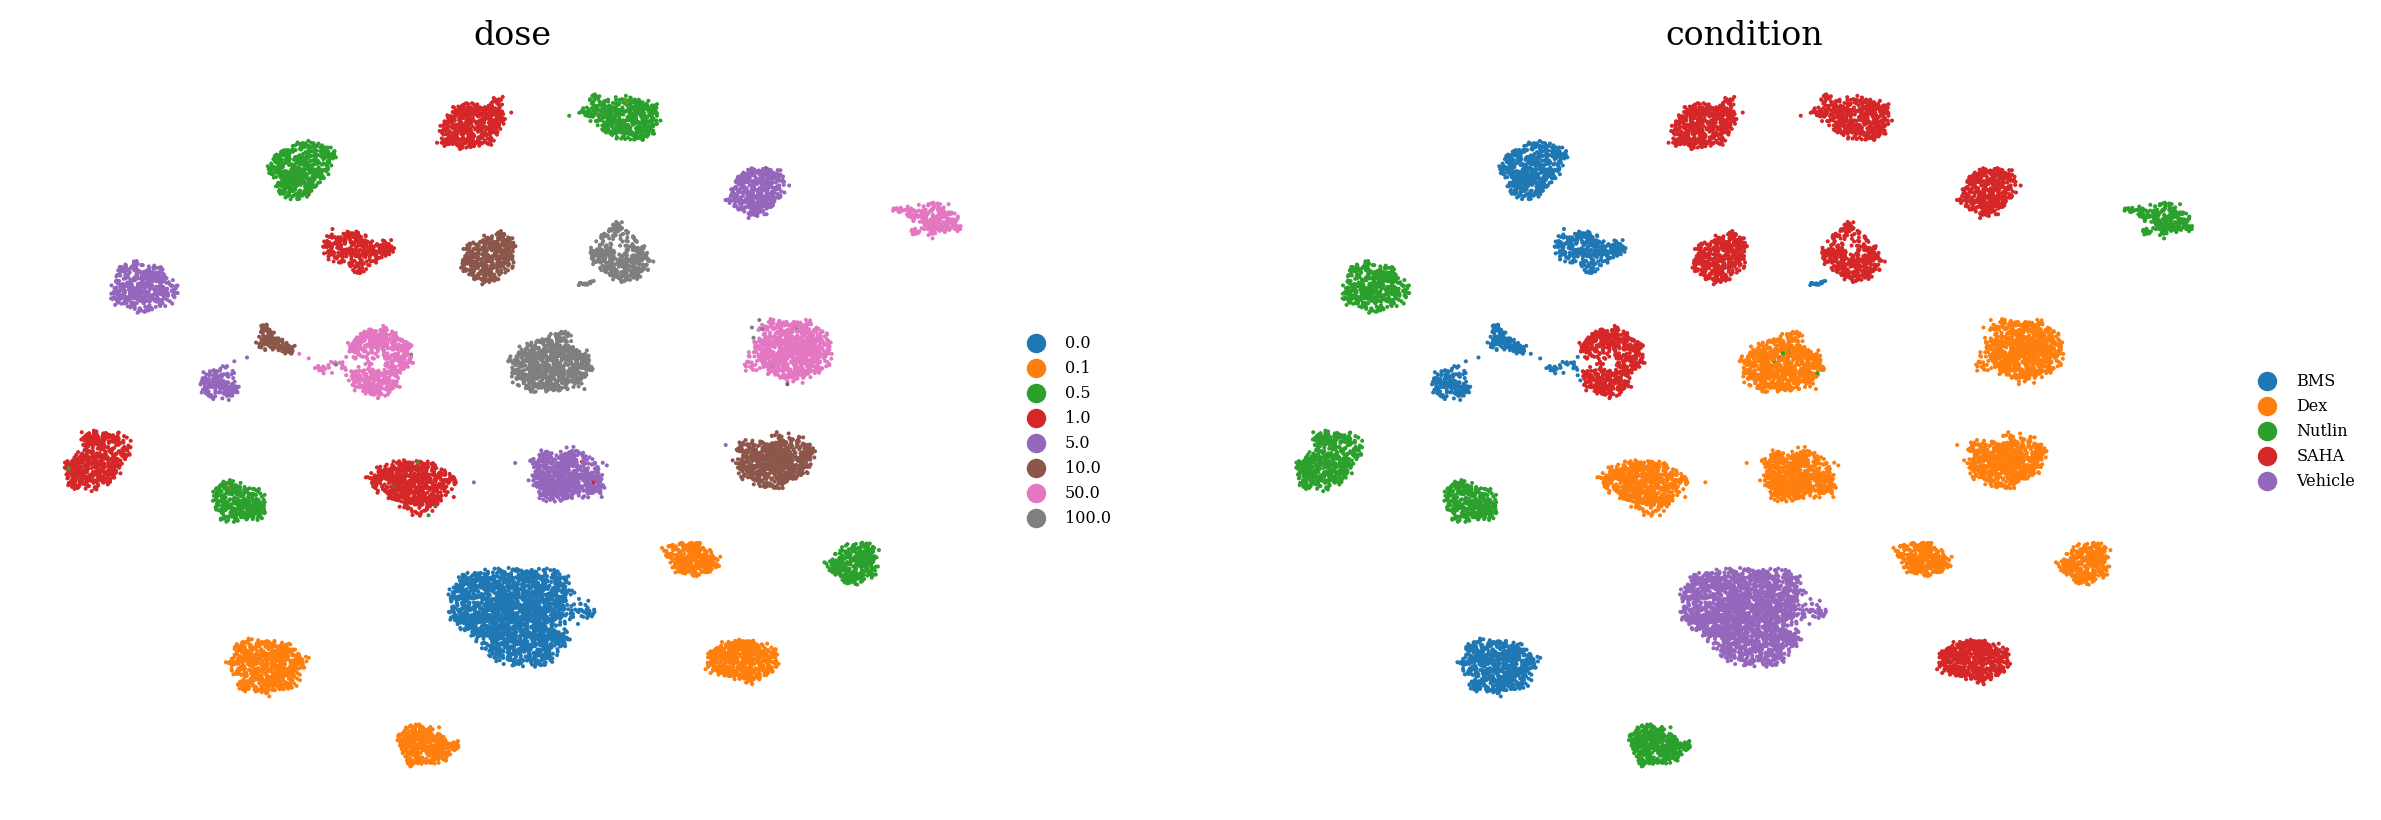

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [25]:
from tardis._disentanglementmanager import DisentanglementManager as DM

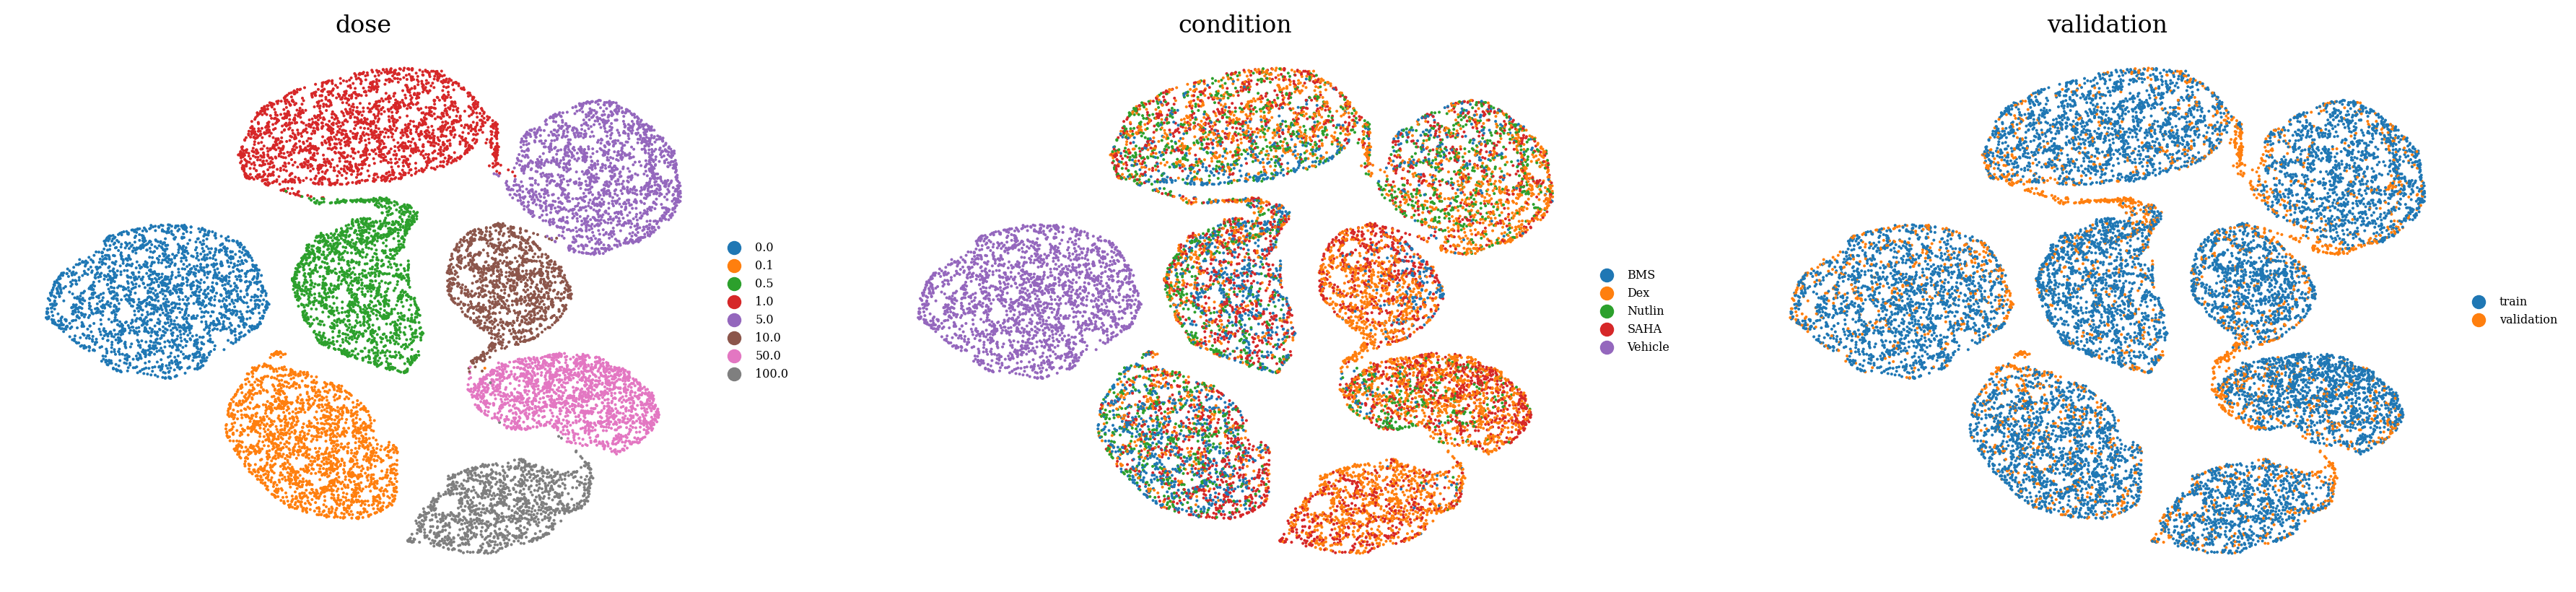

In [26]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

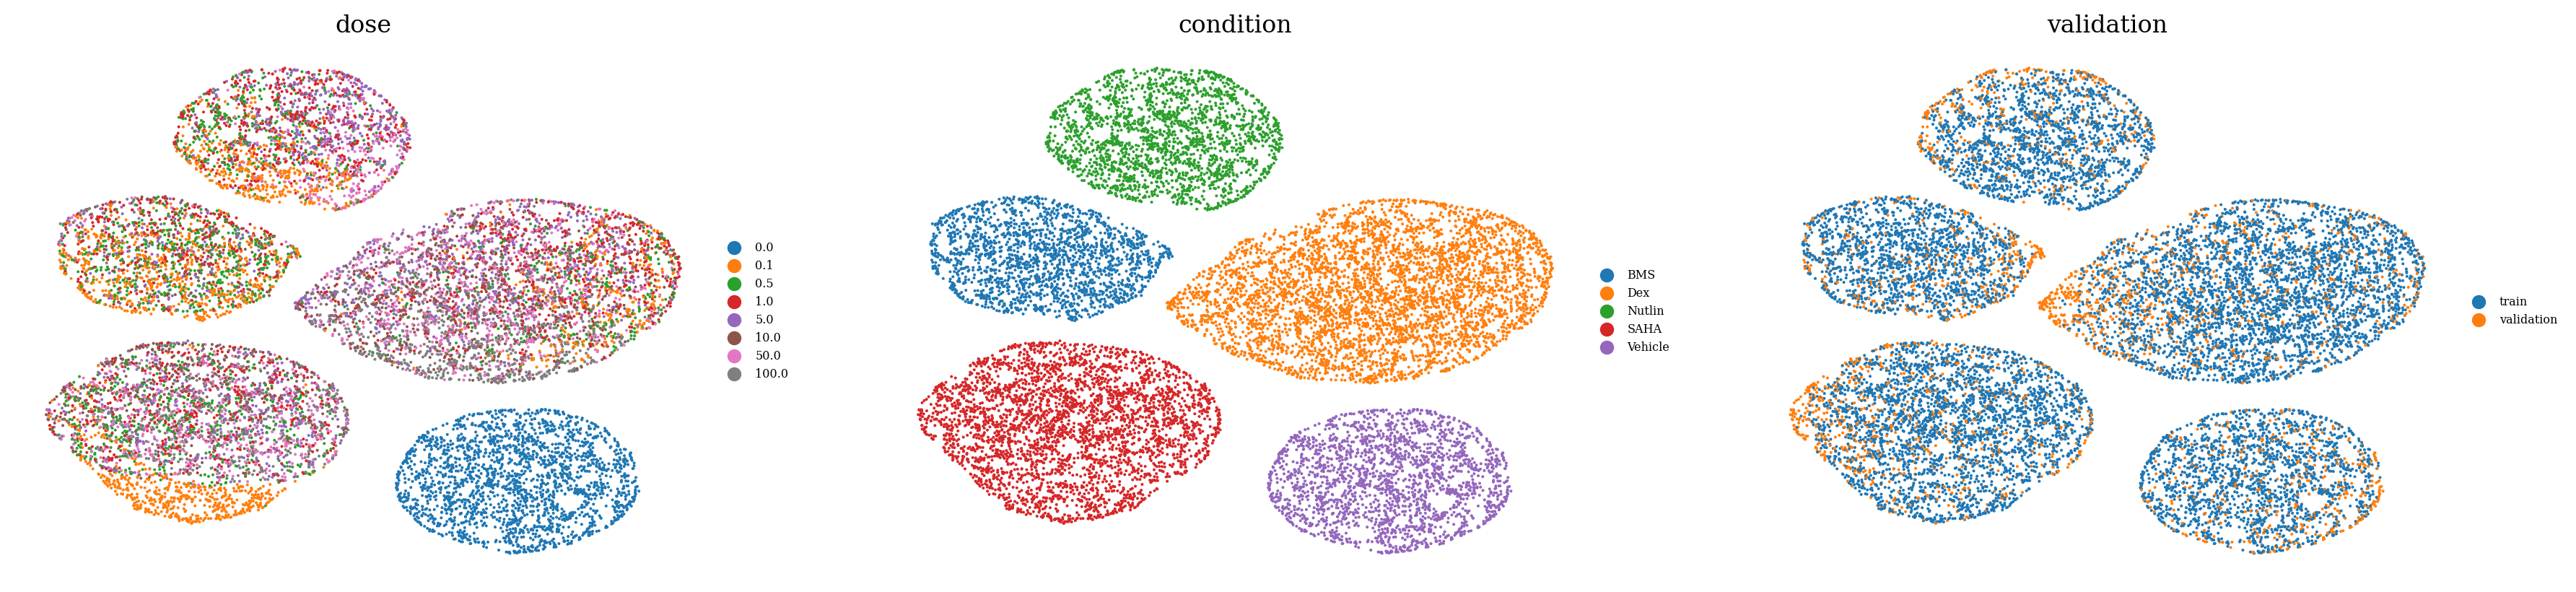

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"],
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )